In [2]:
%matplotlib inline

import math
import datetime

import numpy as np

from pandas import DataFrame
from pandas import concat

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

debug = True

In [3]:
import pip 

cuda = False

l = next(str(i) for i in pip.get_installed_distributions() if 'tensorflow' in str(i))
if l.startswith('tensorflow-gpu'):
    cuda = True

In [4]:
#MATLAB colors
colors = [[0, 0.4470, 0.7410],
          [0.8500, 0.3250, 0.0980],
          [0.9290, 0.6940, 0.1250],
          [0.4940, 0.1840, 0.5560],
          [0.4660, 0.6740, 0.1880],
          [0.3010, 0.7450, 0.9330],
          [0.6350, 0.0780, 0.1840]];

colormap = plt.get_cmap('rainbow')

def getColor(num, brightness=1):
    col = colors[num]
    return [col[0]*brightness, col[1]*brightness, col[2]*brightness]

In [5]:
N = 25 #Number of experiments
 
def encode(msg):
    encoded = [0]*8
    for x in msg:
        if x.startswith('m1'):
            encoded[0] = 1.0
        elif x.startswith('m2'):
            encoded[1] = 1.0
        elif x.startswith('m3'):
            encoded[2] = 1.0
        elif x == 'a':
            encoded[3] = 1.0
        elif x == 'b':
            encoded[4] = 1.0
        elif x == 'c':
            encoded[5] = 1.0  
        elif x == 'd':
            encoded[6] = 1.0   
        elif x == 'e':
            encoded[7] = 1.0
    return encoded

def decode(encoded):
    message = []
    if (encoded[0] > encoded[1] and encoded[0] > encoded[2]):
        message.append('m1')
    elif (encoded[1] > encoded[0] and encoded[1] > encoded[2]):
        message.append('m2')
    elif (encoded[2] > encoded[0] and encoded[2] > encoded[1]):
        message.append('m3')
    else:
        message.append('m?')
        
    if (encoded[3] >= 0.5):
        message.append('a')
    if (encoded[4] >= 0.5):
        message.append('b')
    if (encoded[5] >= 0.5):
        message.append('c')
    if (encoded[6] >= 0.5):
        message.append('d')
    if (encoded[7] >= 0.5):
        message.append('e')        
        
    return message
        

def logToData(filename):
    file = open(filename)
    while True:
        line = file.readline()      
        if not line:
            break        
        if line.startswith('!'):
            raw_bytes = list(line[1:].strip().split(',')[:-1])
            raw_bytes_float = []
            for b in raw_bytes:
                raw_bytes_float.append(int(b)/255)
            while True:
                line = file.readline()      
                if not line:
                    break        
                elif line.startswith('@'):
                    encoded = encode(line.split('@')[2].split(','))
                    yield raw_bytes_float, encoded
                    break;    

In [6]:
def loadAllData(base, N):
    maxbytelen = 0
    logs = []
    for i in range(1,N+1):
        log = list(logToData(base+str(i)+'.log'))
        logs.append(log)
        for msg in log:
            length = len(msg[0])
            maxbytelen = max(maxbytelen, length)
    X = []
    Y = []
    for log in logs:
        x = np.zeros((len(log),maxbytelen))
        y = np.zeros((len(log),8))
        for i, msg in enumerate(log):
            x[i,0:len(msg[0])] = msg[0]
            y[i,:] = msg[1]
        X.append(x)
        Y.append(y)
    return X, Y, maxbytelen

In [7]:
base_dir = '../../../target/thingml-bytes-logs/nodejs/'

base_X, base_Y, base_maxbytelen = loadAllData(base_dir+'base/nodejs', N)
static_X, static_Y, static_maxbytelen = loadAllData(base_dir+'static/nodejs', N)
runtime_X, runtime_Y, runtime_maxbytelen = loadAllData(base_dir+'dynamic/nodejs', N)

In [8]:
def split(data, train_ratio = 0.67):
    train = []
    test = []
    for log in data:
        length = log.shape[0]
        train_size = int(length * train_ratio)
        train.append(log[0:train_size,:])
        test.append(log[train_size:,:])
    return train, test

base_X_train, base_X_test = split(base_X)
base_Y_train, base_Y_test = split(base_Y)
static_X_train, static_X_test = split(static_X)
static_Y_train, static_Y_test = split(static_Y)
runtime_X_train, runtime_X_test = split(runtime_X)
runtime_Y_train, runtime_Y_test = split(runtime_Y)

In [9]:
number_of_interactions = 3 
size_of_interactions = 3

def series_to_supervised(all_data, maxbytelen):
    results = []
    for j in range(0,N):
        result = []
        data = all_data[j].flatten()
        for i in range(0,int(len(data)/(number_of_interactions*size_of_interactions*maxbytelen))):
            time_window = data[i*maxbytelen:number_of_interactions*size_of_interactions*maxbytelen+i*maxbytelen]
            result.append(time_window)
        results.append(result)
    np_results = np.array(results)
    n = number_of_interactions*size_of_interactions
    np_results = np.reshape(np_results, (np_results.shape[0], np_results.shape[1], n, int(np_results.shape[2]/n)))
    return np_results

base_X_train_supervised = series_to_supervised(base_X_train, base_maxbytelen)
static_X_train_supervised = series_to_supervised(static_X_train, static_maxbytelen)
runtime_X_train_supervised = series_to_supervised(runtime_X_train, runtime_maxbytelen)

base_Y_train_supervised = series_to_supervised(base_Y_train, 8)
static_Y_train_supervised = series_to_supervised(static_Y_train, 8)
runtime_Y_train_supervised = series_to_supervised(runtime_Y_train, 8)

base_X_test_supervised = series_to_supervised(base_X_test, base_maxbytelen)
static_X_test_supervised = series_to_supervised(static_X_test, static_maxbytelen)
runtime_X_test_supervised = series_to_supervised(runtime_X_test, runtime_maxbytelen)

base_Y_test_supervised = series_to_supervised(base_Y_test, 8)
static_Y_test_supervised = series_to_supervised(static_Y_test, 8)
runtime_Y_test_supervised = series_to_supervised(runtime_Y_test, 8)

if debug:
    print(base_X_train_supervised.shape, ' ', base_Y_train_supervised.shape)
    print(static_X_train_supervised.shape, ' ', static_Y_train_supervised.shape)
    print(runtime_X_train_supervised.shape, ' ', runtime_Y_train_supervised.shape)

    print(base_X_test_supervised.shape, ' ', base_Y_test_supervised.shape)
    print(static_X_test_supervised.shape, ' ', static_Y_test_supervised.shape)
    print(runtime_X_test_supervised.shape, ' ', runtime_Y_test_supervised.shape)

(25, 55, 9, 7)   (25, 55, 9, 8)
(25, 111, 9, 13)   (25, 111, 9, 8)
(25, 111, 9, 13)   (25, 111, 9, 8)
(25, 27, 9, 7)   (25, 27, 9, 8)
(25, 55, 9, 13)   (25, 55, 9, 8)
(25, 55, 9, 13)   (25, 55, 9, 8)


In [11]:
def keras_model(x, y):    
    model = keras.Sequential()
    #model.add(keras.layers.Dropout(0.2, input_shape=(x,)))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(250, activation='relu', input_dim=x)))
    if cuda:
        model.add(keras.layers.CuDNNLSTM(125, return_sequences=True))
    else:
        model.add(keras.layers.LSTM(125, return_sequences=True))
    #model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(50, activation='relu')))
    #model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(y, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'binary_accuracy'])    
    return model

def train_and_save(model, train_X, train_Y, test_X, test_Y, mode, xp, save=False):        
    earlystop_loss = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.000025, patience=25, verbose=1, mode='min')
    earlystop_val_loss = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.000025, patience=25, verbose=1, mode='min')
    earlystop_acc = keras.callbacks.EarlyStopping(monitor='acc', min_delta=0.000025, patience=25, verbose=1, mode='max')
    earlystop_val_acc = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.000025, patience=25, verbose=1, mode='max')
    callbacks_list = [earlystop_loss, earlystop_val_loss, earlystop_acc, earlystop_val_acc]  
        
    model.fit(train_X, train_Y, batch_size=1, epochs=100, validation_split=0.1, verbose=1, callbacks=callbacks_list)

    if save:
        model.save(base_dir + mode + str(xp) + '_class_lstm.h5')
#     if debug:
#         result = model.evaluate(test_X, test_Y)
#         print(result)
    return model

In [12]:
def predict(model, test_X, test_Y):

    predictions = model.predict(test_X)

    errors = 0
    for i in range(0, predictions.shape[0]):
        for j in range(0, predictions.shape[2], 8):
            predicted = encode(decode(predictions[i][0][j:j+8]))
            truth = test_Y[i][0][j:j+8]
            errs = np.sum(np.abs(predicted - truth))/len(truth)
            if errs > 0:
                errors = errors + errs
                print('Predicting ', decode(predicted), '. Truth is ', decode(truth))    
    error_ratio = round((errors/(test_Y.shape[0]*test_Y.shape[2])*100),2)

    return error_ratio

In [11]:
def xp(train_X, train_Y, test_X, test_Y, mode):
    print('xp ', mode)
    results = []
    for i in range(0, N): 
        print('  #', i)
        print('----')
        model = keras_model(train_X[i].shape[2], train_Y[i].shape[2])
        train_start = datetime.datetime.now()
        model = train_and_save(model, train_X[i], train_Y[i], test_X[i], test_Y[i], mode, i, save=True)
        model.summary()
        train_stop = predict_start = datetime.datetime.now()
        error_ratio = predict(model, test_X[i], test_Y[i])
        predict_stop = datetime.datetime.now()
        train_duration = train_stop - train_start
        predict_duration = predict_stop - predict_start
        print(error_ratio, '% error')
        print('training duration = ', train_duration)
        print('prediction duration = ', predict_duration)
        results.append((error_ratio, train_duration, predict_duration))
    return results

In [12]:
base_results = xp(base_X_train_supervised, base_Y_train_supervised, base_X_test_supervised, base_Y_test_supervised, 'base')
static_results = xp(static_X_train_supervised, static_Y_train_supervised, static_X_test_supervised, static_Y_test_supervised, 'static')
runtime_results = xp(runtime_X_train_supervised, runtime_Y_train_supervised, runtime_X_test_supervised, runtime_Y_test_supervised, 'runtime')

xp  base
  # 0
----
Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 4s 84ms/step - loss: 0.5940 - acc: 0.6942 - binary_accuracy: 0.6942 - val_loss: 0.5614 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 0s 7ms/step - loss: 0.5550 - acc: 0.7083 - binary_accuracy: 0.7083 - val_loss: 0.5453 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 3/100
49/49 [==============================] - 0s 7ms/step - loss: 0.4481 - acc: 0.7721 - binary_accuracy: 0.7721 - val_loss: 0.1983 - val_acc: 0.9537 - val_binary_accuracy: 0.9537
Epoch 4/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0845 - acc: 0.9702 - binary_accuracy: 0.9702 - val_loss: 0.0638 - val_acc: 0.9560 - val_binary_accuracy: 0.9560
Epoch 5/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0450 - acc: 0.9748 - binary_accuracy: 0.9748 - val_loss: 0.0367 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
E

Epoch 23/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0032 - acc: 0.9997 - binary_accuracy: 0.9997 - val_loss: 0.0027 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 24/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0041 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0018 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 25/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0019 - acc: 0.9997 - binary_accuracy: 0.9997 - val_loss: 0.0041 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 26/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0067 - acc: 0.9963 - binary_accuracy: 0.9963 - val_loss: 0.0151 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 27/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0047 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0014 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 28/100
49/49 [==============================] - 0s 9ms

49/49 [==============================] - 0s 7ms/step - loss: 0.0104 - acc: 0.9960 - binary_accuracy: 0.9960 - val_loss: 0.0053 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 27/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0055 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0039 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 28/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0049 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0039 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 29/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0031 - acc: 0.9997 - binary_accuracy: 0.9997 - val_loss: 0.0029 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 30/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0027 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 31/100
49/49 [==============================] - 0s 7ms/step - loss:

49/49 [==============================] - 0s 7ms/step - loss: 0.0074 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0033 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 30/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0081 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0027 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 31/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0065 - acc: 0.9983 - binary_accuracy: 0.9983 - val_loss: 0.0021 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 32/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0054 - acc: 0.9974 - binary_accuracy: 0.9974 - val_loss: 6.9952e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 33/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0078 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0011 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 00033: early stopping
_________________________________________

Epoch 34/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0051 - acc: 0.9983 - binary_accuracy: 0.9983 - val_loss: 0.0035 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 35/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0056 - acc: 0.9986 - binary_accuracy: 0.9986 - val_loss: 0.0038 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 36/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0072 - acc: 0.9963 - binary_accuracy: 0.9963 - val_loss: 0.0031 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 37/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0114 - acc: 0.9943 - binary_accuracy: 0.9943 - val_loss: 0.0050 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 38/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0061 - acc: 0.9986 - binary_accuracy: 0.9986 - val_loss: 0.0039 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 39/100
49/49 [==============================] - 0s 7ms

49/49 [==============================] - 0s 7ms/step - loss: 0.0131 - acc: 0.9938 - binary_accuracy: 0.9938 - val_loss: 0.0062 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 24/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0100 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0046 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 25/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0123 - acc: 0.9969 - binary_accuracy: 0.9969 - val_loss: 0.0040 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 26/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0111 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0118 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 27/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0101 - acc: 0.9974 - binary_accuracy: 0.9974 - val_loss: 0.0076 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 28/100
49/49 [==============================] - 0s 7ms/step - loss:

Epoch 19/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0153 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0113 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 20/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0122 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0088 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 21/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0113 - acc: 0.9969 - binary_accuracy: 0.9969 - val_loss: 0.0074 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 22/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0108 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0080 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 23/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0094 - acc: 0.9986 - binary_accuracy: 0.9986 - val_loss: 0.0051 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 24/100
49/49 [==============================] - 0s 7ms

Epoch 18/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0131 - acc: 0.9963 - binary_accuracy: 0.9963 - val_loss: 0.0162 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 19/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0162 - acc: 0.9943 - binary_accuracy: 0.9943 - val_loss: 0.0111 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 20/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0102 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0143 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 21/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0105 - acc: 0.9949 - binary_accuracy: 0.9949 - val_loss: 0.0086 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 22/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0089 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0114 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 23/100
49/49 [==============================] - 0s 7ms

49/49 [==============================] - 0s 7ms/step - loss: 0.0258 - acc: 0.9861 - binary_accuracy: 0.9861 - val_loss: 0.0228 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 10/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0263 - acc: 0.9850 - binary_accuracy: 0.9850 - val_loss: 0.0242 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 11/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0250 - acc: 0.9824 - binary_accuracy: 0.9824 - val_loss: 0.0193 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 12/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0211 - acc: 0.9901 - binary_accuracy: 0.9901 - val_loss: 0.0173 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 13/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0188 - acc: 0.9904 - binary_accuracy: 0.9904 - val_loss: 0.0153 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 14/100
49/49 [==============================] - 0s 7ms/step - loss:

Epoch 8/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0255 - acc: 0.9850 - binary_accuracy: 0.9850 - val_loss: 0.0239 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 9/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0241 - acc: 0.9884 - binary_accuracy: 0.9884 - val_loss: 0.0234 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 10/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0227 - acc: 0.9892 - binary_accuracy: 0.9892 - val_loss: 0.0216 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 11/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0201 - acc: 0.9895 - binary_accuracy: 0.9895 - val_loss: 0.0182 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 12/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0164 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0153 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 13/100
49/49 [==============================] - 0s 7ms/s

49/49 [==============================] - 0s 7ms/step - loss: 0.1042 - acc: 0.9717 - binary_accuracy: 0.9717 - val_loss: 0.0389 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 5/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0379 - acc: 0.9810 - binary_accuracy: 0.9810 - val_loss: 0.0322 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 6/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0309 - acc: 0.9836 - binary_accuracy: 0.9836 - val_loss: 0.0259 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 7/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0272 - acc: 0.9870 - binary_accuracy: 0.9870 - val_loss: 0.0240 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 8/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0267 - acc: 0.9881 - binary_accuracy: 0.9881 - val_loss: 0.0288 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 9/100
49/49 [==============================] - 0s 7ms/step - loss: 0.02

49/49 [==============================] - 3s 54ms/step - loss: 0.6256 - acc: 0.6811 - binary_accuracy: 0.6811 - val_loss: 0.5644 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 0s 7ms/step - loss: 0.5371 - acc: 0.7083 - binary_accuracy: 0.7083 - val_loss: 0.4679 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 3/100
49/49 [==============================] - 0s 7ms/step - loss: 0.2070 - acc: 0.9246 - binary_accuracy: 0.9246 - val_loss: 0.0465 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 4/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0371 - acc: 0.9816 - binary_accuracy: 0.9816 - val_loss: 0.0324 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 5/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0308 - acc: 0.9819 - binary_accuracy: 0.9819 - val_loss: 0.0280 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 6/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0

0.0 % error
training duration =  0:00:18.687651
prediction duration =  0:00:00.584796
  # 17
----
Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 3s 55ms/step - loss: 0.5933 - acc: 0.6961 - binary_accuracy: 0.6961 - val_loss: 0.5610 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 0s 7ms/step - loss: 0.5512 - acc: 0.7083 - binary_accuracy: 0.7083 - val_loss: 0.5351 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 3/100
49/49 [==============================] - 0s 7ms/step - loss: 0.3738 - acc: 0.8237 - binary_accuracy: 0.8237 - val_loss: 0.1016 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 4/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0556 - acc: 0.9816 - binary_accuracy: 0.9816 - val_loss: 0.0379 - val_acc: 0.9722 - val_binary_accuracy: 0.9722
Epoch 5/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0351 - acc: 0.9799 - binary_accurac

Epoch 44/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0069 - acc: 0.9955 - binary_accuracy: 0.9955 - val_loss: 0.0034 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 45/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0037 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0089 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 46/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0227 - acc: 0.9921 - binary_accuracy: 0.9921 - val_loss: 0.0014 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 00046: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_34 (TimeDis (None, 9, 250)            2000      
_________________________________________________________________
cu_dnnlstm_17 (CuDNNLSTM)    (None, 9, 125)            188500    
_________________________________________________________________
time_distrib

Epoch 37/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0036 - acc: 0.9997 - binary_accuracy: 0.9997 - val_loss: 0.0014 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 38/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0036 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0012 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 39/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0034 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0014 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 40/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0031 - acc: 0.9997 - binary_accuracy: 0.9997 - val_loss: 8.8622e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 41/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0028 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 0.0013 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 00041: early stopping
____________________________

Epoch 28/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0018 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0126 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 29/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0020 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0212 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 30/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0019 - acc: 0.9997 - binary_accuracy: 0.9997 - val_loss: 0.0189 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 31/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0024 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 32/100
49/49 [==============================] - 0s 7ms/step - loss: 9.7062e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0074 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 33/100
49/49 [==============================] - 0s

Epoch 23/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0079 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0075 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 24/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0094 - acc: 0.9943 - binary_accuracy: 0.9943 - val_loss: 0.0027 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 25/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0073 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0037 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 26/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0061 - acc: 0.9974 - binary_accuracy: 0.9974 - val_loss: 0.0016 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 27/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0052 - acc: 0.9969 - binary_accuracy: 0.9969 - val_loss: 0.0013 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 28/100
49/49 [==============================] - 0s 7ms

49/49 [==============================] - 0s 7ms/step - loss: 0.0081 - acc: 0.9974 - binary_accuracy: 0.9974 - val_loss: 0.0063 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 26/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0051 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0023 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 27/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0055 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0047 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 28/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0044 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 0.0041 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 29/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0037 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0045 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 30/100
49/49 [==============================] - 0s 7ms/step - loss:

99/99 [==============================] - 1s 7ms/step - loss: 0.0065 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0052 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 27/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0065 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0051 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 28/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0063 - acc: 0.9969 - binary_accuracy: 0.9969 - val_loss: 0.0053 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 29/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0061 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0053 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 30/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0059 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0048 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 31/100
99/99 [==============================] - 1s 7ms/step - loss:

99/99 [==============================] - 1s 7ms/step - loss: 0.0142 - acc: 0.9916 - binary_accuracy: 0.9916 - val_loss: 0.0133 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 22/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0141 - acc: 0.9923 - binary_accuracy: 0.9923 - val_loss: 0.0140 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 23/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0139 - acc: 0.9926 - binary_accuracy: 0.9926 - val_loss: 0.0139 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 24/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0141 - acc: 0.9919 - binary_accuracy: 0.9919 - val_loss: 0.0137 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 25/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0140 - acc: 0.9930 - binary_accuracy: 0.9930 - val_loss: 0.0133 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 26/100
99/99 [==============================] - 1s 7ms/step - loss:

Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1'] . Truth is  ['m2']
1.08 % error
training duration =  0:00:27.004408
prediction duration =  0:00:01.007592
  # 4
----
Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 4s 45ms/step - loss: 0.3793 - acc: 0.8378 - binary_accuracy: 0.8378 - val_loss: 0.0

Epoch 2/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0789 - acc: 0.9714 - binary_accuracy: 0.9714 - val_loss: 0.0611 - val_acc: 0.9711 - val_binary_accuracy: 0.9711
Epoch 3/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0522 - acc: 0.9770 - binary_accuracy: 0.9770 - val_loss: 0.0442 - val_acc: 0.9769 - val_binary_accuracy: 0.9769
Epoch 4/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0423 - acc: 0.9756 - binary_accuracy: 0.9756 - val_loss: 0.0400 - val_acc: 0.9780 - val_binary_accuracy: 0.9780
Epoch 5/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0411 - acc: 0.9797 - binary_accuracy: 0.9797 - val_loss: 0.0451 - val_acc: 0.9769 - val_binary_accuracy: 0.9769
Epoch 6/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0404 - acc: 0.9774 - binary_accuracy: 0.9774 - val_loss: 0.0385 - val_acc: 0.9792 - val_binary_accuracy: 0.9792
Epoch 7/100
99/99 [==============================] - 1s 7ms/step 

Epoch 46/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0279 - acc: 0.9860 - binary_accuracy: 0.9860 - val_loss: 0.0228 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 47/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0277 - acc: 0.9870 - binary_accuracy: 0.9870 - val_loss: 0.0219 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 48/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0285 - acc: 0.9846 - binary_accuracy: 0.9846 - val_loss: 0.0206 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 49/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0275 - acc: 0.9870 - binary_accuracy: 0.9870 - val_loss: 0.0215 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 50/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0274 - acc: 0.9861 - binary_accuracy: 0.9861 - val_loss: 0.0216 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 51/100
99/99 [==============================] - 1s 8ms

99/99 [==============================] - 1s 7ms/step - loss: 0.2036 - acc: 0.9249 - binary_accuracy: 0.9249 - val_loss: 0.0712 - val_acc: 0.9826 - val_binary_accuracy: 0.9826
Epoch 3/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0457 - acc: 0.9870 - binary_accuracy: 0.9870 - val_loss: 0.0350 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 4/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0292 - acc: 0.9902 - binary_accuracy: 0.9902 - val_loss: 0.0358 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 5/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0233 - acc: 0.9900 - binary_accuracy: 0.9900 - val_loss: 0.0223 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 6/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0212 - acc: 0.9907 - binary_accuracy: 0.9907 - val_loss: 0.0214 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 7/100
99/99 [==============================] - 1s 8ms/step - loss: 0.02

Epoch 46/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0071 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0066 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 47/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0070 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0066 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 48/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0067 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0065 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 49/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0071 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0064 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 50/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0071 - acc: 0.9959 - binary_accuracy: 0.9959 - val_loss: 0.0066 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 51/100
99/99 [==============================] - 1s 8ms

Epoch 30/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0230 - acc: 0.9909 - binary_accuracy: 0.9909 - val_loss: 0.0123 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 31/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0113 - acc: 0.9941 - binary_accuracy: 0.9941 - val_loss: 0.0097 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 32/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0115 - acc: 0.9941 - binary_accuracy: 0.9941 - val_loss: 0.0090 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 33/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0109 - acc: 0.9935 - binary_accuracy: 0.9935 - val_loss: 0.0092 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 34/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0114 - acc: 0.9934 - binary_accuracy: 0.9934 - val_loss: 0.0136 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 35/100
99/99 [==============================] - 1s 8ms

99/99 [==============================] - 1s 8ms/step - loss: 0.0112 - acc: 0.9937 - binary_accuracy: 0.9937 - val_loss: 0.0115 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 27/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0139 - acc: 0.9928 - binary_accuracy: 0.9928 - val_loss: 0.0089 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 28/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0092 - acc: 0.9942 - binary_accuracy: 0.9942 - val_loss: 0.0093 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 29/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0092 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0086 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 30/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0089 - acc: 0.9940 - binary_accuracy: 0.9940 - val_loss: 0.0081 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 31/100
99/99 [==============================] - 1s 8ms/step - loss:

Epoch 11/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0357 - acc: 0.9798 - binary_accuracy: 0.9798 - val_loss: 0.0363 - val_acc: 0.9769 - val_binary_accuracy: 0.9769
Epoch 12/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0347 - acc: 0.9794 - binary_accuracy: 0.9794 - val_loss: 0.0346 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 13/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0358 - acc: 0.9801 - binary_accuracy: 0.9801 - val_loss: 0.0345 - val_acc: 0.9792 - val_binary_accuracy: 0.9792
Epoch 14/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0335 - acc: 0.9805 - binary_accuracy: 0.9805 - val_loss: 0.0339 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 15/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0330 - acc: 0.9794 - binary_accuracy: 0.9794 - val_loss: 0.0342 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 16/100
99/99 [==============================] - 1s 8ms

99/99 [==============================] - 1s 8ms/step - loss: 0.0330 - acc: 0.9848 - binary_accuracy: 0.9848 - val_loss: 0.0289 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 11/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0312 - acc: 0.9861 - binary_accuracy: 0.9861 - val_loss: 0.0273 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 12/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0307 - acc: 0.9858 - binary_accuracy: 0.9858 - val_loss: 0.0322 - val_acc: 0.9850 - val_binary_accuracy: 0.9850
Epoch 13/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0284 - acc: 0.9885 - binary_accuracy: 0.9885 - val_loss: 0.0250 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 14/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0274 - acc: 0.9878 - binary_accuracy: 0.9878 - val_loss: 0.0239 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 15/100
99/99 [==============================] - 1s 8ms/step - loss:

Epoch 54/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0075 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0071 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 55/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0073 - acc: 0.9951 - binary_accuracy: 0.9951 - val_loss: 0.0069 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 56/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0074 - acc: 0.9955 - binary_accuracy: 0.9955 - val_loss: 0.0068 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 57/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0071 - acc: 0.9962 - binary_accuracy: 0.9962 - val_loss: 0.0069 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 58/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0074 - acc: 0.9951 - binary_accuracy: 0.9951 - val_loss: 0.0068 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 59/100
99/99 [==============================] - 1s 8ms

Epoch 31/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0177 - acc: 0.9906 - binary_accuracy: 0.9906 - val_loss: 0.0170 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 32/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0176 - acc: 0.9906 - binary_accuracy: 0.9906 - val_loss: 0.0167 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 33/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0175 - acc: 0.9906 - binary_accuracy: 0.9906 - val_loss: 0.0164 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 34/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0183 - acc: 0.9905 - binary_accuracy: 0.9905 - val_loss: 0.0164 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 35/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0173 - acc: 0.9910 - binary_accuracy: 0.9910 - val_loss: 0.0164 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 36/100
99/99 [==============================] - 1s 8ms

Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 6s 56ms/step - loss: 0.4205 - acc: 0.8103 - binary_accuracy: 0.8103 - val_loss: 0.0678 - val_acc: 0.9780 - val_binary_accuracy: 0.9780
Epoch 2/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0478 - acc: 0.9819 - binary_accuracy: 0.9819 - val_loss: 0.0334 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 3/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0364 - acc: 0.9847 - binary_accuracy: 0.9847 - val_loss: 0.0319 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 4/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0282 - acc: 0.9886 - binary_accuracy: 0.9886 - val_loss: 0.0231 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 5/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0237 - acc: 0.9898 - binary_accuracy: 0.9898 - val_loss: 0.0203 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 6/100
99/99 [=

Epoch 47/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0060 - acc: 0.9979 - binary_accuracy: 0.9979 - val_loss: 0.0032 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 00047: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_80 (TimeDis (None, 9, 250)            3500      
_________________________________________________________________
cu_dnnlstm_40 (CuDNNLSTM)    (None, 9, 125)            188500    
_________________________________________________________________
time_distributed_81 (TimeDis (None, 9, 50)             6300      
_________________________________________________________________
dense_122 (Dense)            (None, 9, 8)              408       
Total params: 198,708
Trainable params: 198,708
Non-trainable params: 0
_________________________________________________________________
0.0 % error
training duration =  0:00:45.330735
pred

Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
0.51 % error
training duration =  0:00:35.552023
prediction duration =  0:00:01.461189
  # 17
----
Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 6s 61ms/step - loss: 0.6032 - acc: 0.6874 - binary_accuracy: 0.6874 - val_loss: 0.5422 - val_acc: 0.7164 - val_binary_accuracy: 0.7164
Epoch 2/100
99/99 [==============================] - 1s 8ms/step - loss: 0.2504 - acc: 0.8876 - binary_accuracy: 0.8876 - val_loss: 0.0826 - val_acc: 0.9653 - val_binary_accuracy: 0.9653
Epoch 3/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0602 - acc: 0.9776 - binary_accuracy: 0.9776 - val_loss: 0.0476 -

Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 6s 62ms/step - loss: 0.3728 - acc: 0.8311 - binary_accuracy: 0.8311 - val_loss: 0.0509 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 2/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0357 - acc: 0.9851 - binary_accuracy: 0.9851 - val_loss: 0.0303 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 3/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0297 - acc: 0.9858 - binary_accuracy: 0.9858 - val_loss: 0.0272 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 4/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0272 - acc: 0.9858 - binary_accuracy: 0.9858 - val_loss: 0.0249 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 5/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0240 - acc: 0.9889 - binary_accuracy: 0.9889 - val_loss: 0.0220 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 6/100
99/99 [=

99/99 [==============================] - 6s 64ms/step - loss: 0.3371 - acc: 0.8509 - binary_accuracy: 0.8509 - val_loss: 0.0390 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 2/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0264 - acc: 0.9903 - binary_accuracy: 0.9903 - val_loss: 0.0211 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 3/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0202 - acc: 0.9896 - binary_accuracy: 0.9896 - val_loss: 0.0187 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 4/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0186 - acc: 0.9895 - binary_accuracy: 0.9895 - val_loss: 0.0197 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 5/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0191 - acc: 0.9906 - binary_accuracy: 0.9906 - val_loss: 0.0168 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 6/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0

99/99 [==============================] - 1s 8ms/step - loss: 0.0286 - acc: 0.9841 - binary_accuracy: 0.9841 - val_loss: 0.0294 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 14/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0286 - acc: 0.9834 - binary_accuracy: 0.9834 - val_loss: 0.0257 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 15/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0283 - acc: 0.9844 - binary_accuracy: 0.9844 - val_loss: 0.0247 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 16/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0274 - acc: 0.9853 - binary_accuracy: 0.9853 - val_loss: 0.0239 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 17/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0265 - acc: 0.9863 - binary_accuracy: 0.9863 - val_loss: 0.0230 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 18/100
99/99 [==============================] - 1s 8ms/step - loss:

Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
1.28 % error
training duration =  0:00:50.808865
prediction duration =  0:00:01.703562
  # 23
----
Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [===================

99/99 [==============================] - 1s 8ms/step - loss: 0.0066 - acc: 0.9949 - binary_accuracy: 0.9949 - val_loss: 0.0064 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 29/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0068 - acc: 0.9949 - binary_accuracy: 0.9949 - val_loss: 0.0066 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 30/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0065 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0086 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 31/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0073 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0065 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 00031: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_98 (TimeDis (None, 9, 250)            3500      
___________________________________

99/99 [==============================] - 1s 8ms/step - loss: 0.0928 - acc: 0.9558 - binary_accuracy: 0.9558 - val_loss: 0.0646 - val_acc: 0.9792 - val_binary_accuracy: 0.9792
Epoch 10/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0841 - acc: 0.9590 - binary_accuracy: 0.9590 - val_loss: 0.0576 - val_acc: 0.9745 - val_binary_accuracy: 0.9745
Epoch 11/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0797 - acc: 0.9652 - binary_accuracy: 0.9652 - val_loss: 0.0622 - val_acc: 0.9711 - val_binary_accuracy: 0.9711
Epoch 12/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0759 - acc: 0.9677 - binary_accuracy: 0.9677 - val_loss: 0.0408 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 13/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0654 - acc: 0.9731 - binary_accuracy: 0.9731 - val_loss: 0.0366 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 14/100
99/99 [==============================] - 1s 8ms/step - loss:

Epoch 53/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0184 - acc: 0.9914 - binary_accuracy: 0.9914 - val_loss: 0.0109 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 00053: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_102 (TimeDi (None, 9, 250)            3500      
_________________________________________________________________
cu_dnnlstm_51 (CuDNNLSTM)    (None, 9, 125)            188500    
_________________________________________________________________
time_distributed_103 (TimeDi (None, 9, 50)             6300      
_________________________________________________________________
dense_155 (Dense)            (None, 9, 8)              408       
Total params: 198,708
Trainable params: 198,708
Non-trainable params: 0
_________________________________________________________________
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['

Epoch 26/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0127 - acc: 0.9942 - binary_accuracy: 0.9942 - val_loss: 0.0269 - val_acc: 0.9826 - val_binary_accuracy: 0.9826
Epoch 27/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0124 - acc: 0.9941 - binary_accuracy: 0.9941 - val_loss: 0.0255 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 28/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0106 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0217 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 29/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0104 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0225 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 30/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0095 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0247 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 31/100
99/99 [==============================] - 1s 8ms

Epoch 57/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0262 - acc: 0.9902 - binary_accuracy: 0.9902 - val_loss: 0.1327 - val_acc: 0.9630 - val_binary_accuracy: 0.9630
Epoch 58/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0146 - acc: 0.9935 - binary_accuracy: 0.9935 - val_loss: 0.0629 - val_acc: 0.9769 - val_binary_accuracy: 0.9769
Epoch 59/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0094 - acc: 0.9962 - binary_accuracy: 0.9962 - val_loss: 0.0646 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 60/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0090 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0655 - val_acc: 0.9826 - val_binary_accuracy: 0.9826
Epoch 61/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0085 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0619 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 62/100
99/99 [==============================] - 1s 8ms

Epoch 16/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0194 - acc: 0.9910 - binary_accuracy: 0.9910 - val_loss: 0.0477 - val_acc: 0.9745 - val_binary_accuracy: 0.9745
Epoch 17/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0184 - acc: 0.9914 - binary_accuracy: 0.9914 - val_loss: 0.0367 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 18/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0198 - acc: 0.9910 - binary_accuracy: 0.9910 - val_loss: 0.0590 - val_acc: 0.9745 - val_binary_accuracy: 0.9745
Epoch 19/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0190 - acc: 0.9916 - binary_accuracy: 0.9916 - val_loss: 0.0250 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 20/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0179 - acc: 0.9920 - binary_accuracy: 0.9920 - val_loss: 0.0287 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 21/100
99/99 [==============================] - 1s 8ms

Epoch 55/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0188 - acc: 0.9895 - binary_accuracy: 0.9895 - val_loss: 0.0166 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 56/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0188 - acc: 0.9912 - binary_accuracy: 0.9912 - val_loss: 0.0204 - val_acc: 0.9850 - val_binary_accuracy: 0.9850
Epoch 57/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0184 - acc: 0.9902 - binary_accuracy: 0.9902 - val_loss: 0.0173 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 58/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0180 - acc: 0.9903 - binary_accuracy: 0.9903 - val_loss: 0.0191 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 59/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0175 - acc: 0.9903 - binary_accuracy: 0.9903 - val_loss: 0.0183 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 60/100
99/99 [==============================] - 1s 8ms

99/99 [==============================] - 1s 8ms/step - loss: 0.0069 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0303 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 36/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0065 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0211 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 37/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0066 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0392 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 38/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0082 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0415 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 39/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0067 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0462 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 40/100
99/99 [==============================] - 1s 8ms/step - loss:

Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'c'] . Truth is  ['m2', 'c']
0.14 % error
training duration =  0:01:00.515219
prediction duration =  0:00:02.188815
  # 10
----
Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 8s 85ms/step - loss: 0.5021 - acc: 0.7591 - binary_accuracy: 0.7591 - val_loss: 0.3423 - val_acc: 0.8657 - val_binary_accuracy: 0.8657
Epoch 2/100
99/99 [==============================] - 1s 8ms/step - loss: 0.1743 - acc: 0.9299 - binary_accuracy: 0.9299 - val_loss: 0.1903 - val_acc: 0.9340 - val_binary_accuracy: 0.9340
Epoch 3/100
99/99 [==============================] - 1s 8ms/step - loss: 0.1275 - acc: 0.9499 - binary_accuracy: 0.9499 - val_loss: 0.1576 - val_acc: 0.9525 - val_binary_accuracy: 0.9525
Epoch 4/100
99/99 [==============================] - 1s 8ms/step - loss: 0.1052 - acc: 0.9569 - binary_accuracy: 0.9569 - val_loss: 0.1365 - val_acc: 0.9572 - val_binary_accuracy: 0.9572
Epoch 5/100
99/99

Epoch 9/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0543 - acc: 0.9756 - binary_accuracy: 0.9756 - val_loss: 0.0362 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 10/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0477 - acc: 0.9792 - binary_accuracy: 0.9792 - val_loss: 0.0440 - val_acc: 0.9850 - val_binary_accuracy: 0.9850
Epoch 11/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0418 - acc: 0.9818 - binary_accuracy: 0.9818 - val_loss: 0.0274 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 12/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0414 - acc: 0.9812 - binary_accuracy: 0.9812 - val_loss: 0.0336 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 13/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0329 - acc: 0.9860 - binary_accuracy: 0.9860 - val_loss: 0.0509 - val_acc: 0.9757 - val_binary_accuracy: 0.9757
Epoch 14/100
99/99 [==============================] - 1s 8ms/

Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m2']
0.57 % error
training duration =  0:00:53.542693
prediction duration =  0:00:02.263544
  # 12
----
Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 9s 87ms/step - loss: 0.5535 - acc: 0.7273 - binary_accuracy: 0.7273 - val_loss: 0.3531 - val_acc: 0.8426 - val_binary_accuracy: 0.8426
Epoch 2/100
99/99 [==============================] - 1s 8ms/step - loss: 0.1595 - acc: 0.9390 - binary_accuracy: 0.9390 - val_loss: 0.2586 - val_acc: 0.8924 - val_binary_accuracy: 0.8924
Epoch 3/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0612 - acc: 0.9816 - binary

Epoch 51/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0109 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0309 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 52/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0090 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0376 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 53/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0095 - acc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 0.0384 - val_acc: 0.9850 - val_binary_accuracy: 0.9850
Epoch 54/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0118 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0344 - val_acc: 0.9826 - val_binary_accuracy: 0.9826
Epoch 55/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0109 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0337 - val_acc: 0.9850 - val_binary_accuracy: 0.9850
Epoch 56/100
99/99 [==============================] - 1s 8ms

Epoch 32/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0208 - acc: 0.9893 - binary_accuracy: 0.9893 - val_loss: 0.0935 - val_acc: 0.9560 - val_binary_accuracy: 0.9560
Epoch 33/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0209 - acc: 0.9891 - binary_accuracy: 0.9891 - val_loss: 0.1206 - val_acc: 0.9618 - val_binary_accuracy: 0.9618
Epoch 34/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0200 - acc: 0.9905 - binary_accuracy: 0.9905 - val_loss: 0.1303 - val_acc: 0.9595 - val_binary_accuracy: 0.9595
Epoch 35/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0190 - acc: 0.9914 - binary_accuracy: 0.9914 - val_loss: 0.1109 - val_acc: 0.9618 - val_binary_accuracy: 0.9618
Epoch 36/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0178 - acc: 0.9927 - binary_accuracy: 0.9927 - val_loss: 0.1644 - val_acc: 0.9560 - val_binary_accuracy: 0.9560
Epoch 37/100
99/99 [==============================] - 1s 8ms

Epoch 27/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0440 - acc: 0.9780 - binary_accuracy: 0.9780 - val_loss: 0.0657 - val_acc: 0.9722 - val_binary_accuracy: 0.9722
Epoch 28/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0434 - acc: 0.9787 - binary_accuracy: 0.9787 - val_loss: 0.0422 - val_acc: 0.9792 - val_binary_accuracy: 0.9792
Epoch 29/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0420 - acc: 0.9799 - binary_accuracy: 0.9799 - val_loss: 0.0345 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 30/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0380 - acc: 0.9827 - binary_accuracy: 0.9827 - val_loss: 0.0392 - val_acc: 0.9780 - val_binary_accuracy: 0.9780
Epoch 31/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0381 - acc: 0.9825 - binary_accuracy: 0.9825 - val_loss: 0.0443 - val_acc: 0.9757 - val_binary_accuracy: 0.9757
Epoch 32/100
99/99 [==============================] - 1s 9ms

Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 9s 96ms/step - loss: 0.6099 - acc: 0.6887 - binary_accuracy: 0.6887 - val_loss: 0.5809 - val_acc: 0.6933 - val_binary_accuracy: 0.6933
Epoch 2/100
99/99 [==============================] - 1s 8ms/step - loss: 0.4947 - acc: 0.7511 - binary_accuracy: 0.7511 - val_loss: 0.3644 - val_acc: 0.8345 - val_binary_accuracy: 0.8345
Epoch 3/100
99/99 [==============================] - 1s 8ms/step - loss: 0.2744 - acc: 0.8829 - binary_accuracy: 0.8829 - val_loss: 0.1956 - val_acc: 0.9132 - val_binary_accuracy: 0.9132
Epoch 4/100
99/99 [==============================] - 1s 8ms/step - loss: 0.1739 - acc: 0.9249 - binary_accuracy: 0.9249 - val_loss: 0.1431 - val_acc: 0.9282 - val_binary_accuracy: 0.9282
Epoch 5/100
99/99 [==============================] - 1s 8ms/step - loss: 0.1196 - acc: 0.9477 - binary_accuracy: 0.9477 - val_loss: 0.1205 - val_acc: 0.9410 - val_binary_accuracy: 0.9410
Epoch 6/100
99/99 [=

99/99 [==============================] - 1s 9ms/step - loss: 0.1031 - acc: 0.9491 - binary_accuracy: 0.9491 - val_loss: 0.1094 - val_acc: 0.9514 - val_binary_accuracy: 0.9514
Epoch 11/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0977 - acc: 0.9513 - binary_accuracy: 0.9513 - val_loss: 0.0920 - val_acc: 0.9560 - val_binary_accuracy: 0.9560
Epoch 12/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0946 - acc: 0.9537 - binary_accuracy: 0.9537 - val_loss: 0.0947 - val_acc: 0.9537 - val_binary_accuracy: 0.9537
Epoch 13/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0924 - acc: 0.9565 - binary_accuracy: 0.9565 - val_loss: 0.0829 - val_acc: 0.9606 - val_binary_accuracy: 0.9606
Epoch 14/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0891 - acc: 0.9589 - binary_accuracy: 0.9589 - val_loss: 0.0857 - val_acc: 0.9595 - val_binary_accuracy: 0.9595
Epoch 15/100
99/99 [==============================] - 1s 8ms/step - loss:

Epoch 54/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0317 - acc: 0.9832 - binary_accuracy: 0.9832 - val_loss: 0.0521 - val_acc: 0.9769 - val_binary_accuracy: 0.9769
Epoch 55/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0303 - acc: 0.9857 - binary_accuracy: 0.9857 - val_loss: 0.1339 - val_acc: 0.9491 - val_binary_accuracy: 0.9491
Epoch 56/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0319 - acc: 0.9827 - binary_accuracy: 0.9827 - val_loss: 0.0700 - val_acc: 0.9687 - val_binary_accuracy: 0.9687
Epoch 57/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0323 - acc: 0.9815 - binary_accuracy: 0.9815 - val_loss: 0.0509 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 58/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0315 - acc: 0.9834 - binary_accuracy: 0.9834 - val_loss: 0.0614 - val_acc: 0.9734 - val_binary_accuracy: 0.9734
Epoch 59/100
99/99 [==============================] - 1s 9ms

Epoch 7/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0501 - acc: 0.9760 - binary_accuracy: 0.9760 - val_loss: 0.0255 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 8/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0411 - acc: 0.9830 - binary_accuracy: 0.9830 - val_loss: 0.0258 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 9/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0423 - acc: 0.9818 - binary_accuracy: 0.9818 - val_loss: 0.0242 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 10/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0380 - acc: 0.9832 - binary_accuracy: 0.9832 - val_loss: 0.0187 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 11/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0366 - acc: 0.9837 - binary_accuracy: 0.9837 - val_loss: 0.0246 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 12/100
99/99 [==============================] - 1s 9ms/st

99/99 [==============================] - 1s 8ms/step - loss: 0.2644 - acc: 0.8671 - binary_accuracy: 0.8671 - val_loss: 0.2663 - val_acc: 0.8403 - val_binary_accuracy: 0.8403
Epoch 8/100
99/99 [==============================] - 1s 9ms/step - loss: 0.2500 - acc: 0.8756 - binary_accuracy: 0.8756 - val_loss: 0.2710 - val_acc: 0.8461 - val_binary_accuracy: 0.8461
Epoch 9/100
99/99 [==============================] - 1s 9ms/step - loss: 0.2584 - acc: 0.8702 - binary_accuracy: 0.8702 - val_loss: 0.2736 - val_acc: 0.8403 - val_binary_accuracy: 0.8403
Epoch 10/100
99/99 [==============================] - 1s 9ms/step - loss: 0.2450 - acc: 0.8775 - binary_accuracy: 0.8775 - val_loss: 0.2876 - val_acc: 0.8484 - val_binary_accuracy: 0.8484
Epoch 11/100
99/99 [==============================] - 1s 9ms/step - loss: 0.2380 - acc: 0.8833 - binary_accuracy: 0.8833 - val_loss: 0.2755 - val_acc: 0.8484 - val_binary_accuracy: 0.8484
Epoch 12/100
99/99 [==============================] - 1s 8ms/step - loss: 0

Epoch 51/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0410 - acc: 0.9840 - binary_accuracy: 0.9840 - val_loss: 0.1003 - val_acc: 0.9468 - val_binary_accuracy: 0.9468
Epoch 52/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0402 - acc: 0.9834 - binary_accuracy: 0.9834 - val_loss: 0.0993 - val_acc: 0.9410 - val_binary_accuracy: 0.9410
Epoch 53/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0430 - acc: 0.9827 - binary_accuracy: 0.9827 - val_loss: 0.0966 - val_acc: 0.9502 - val_binary_accuracy: 0.9502
Epoch 54/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0453 - acc: 0.9813 - binary_accuracy: 0.9813 - val_loss: 0.0923 - val_acc: 0.9618 - val_binary_accuracy: 0.9618
Epoch 55/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0461 - acc: 0.9809 - binary_accuracy: 0.9809 - val_loss: 0.0929 - val_acc: 0.9549 - val_binary_accuracy: 0.9549
Epoch 56/100
99/99 [==============================] - 1s 9ms

Epoch 30/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0506 - acc: 0.9736 - binary_accuracy: 0.9736 - val_loss: 0.0368 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 31/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0498 - acc: 0.9760 - binary_accuracy: 0.9760 - val_loss: 0.0377 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 32/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0552 - acc: 0.9738 - binary_accuracy: 0.9738 - val_loss: 0.0426 - val_acc: 0.9792 - val_binary_accuracy: 0.9792
Epoch 33/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0495 - acc: 0.9760 - binary_accuracy: 0.9760 - val_loss: 0.0380 - val_acc: 0.9850 - val_binary_accuracy: 0.9850
Epoch 34/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0475 - acc: 0.9757 - binary_accuracy: 0.9757 - val_loss: 0.0358 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 35/100
99/99 [==============================] - 1s 9ms

99/99 [==============================] - 1s 9ms/step - loss: 0.0434 - acc: 0.9827 - binary_accuracy: 0.9827 - val_loss: 0.2093 - val_acc: 0.9502 - val_binary_accuracy: 0.9502
Epoch 10/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0369 - acc: 0.9834 - binary_accuracy: 0.9834 - val_loss: 0.2117 - val_acc: 0.9537 - val_binary_accuracy: 0.9537
Epoch 11/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0350 - acc: 0.9865 - binary_accuracy: 0.9865 - val_loss: 0.2046 - val_acc: 0.9525 - val_binary_accuracy: 0.9525
Epoch 12/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0321 - acc: 0.9875 - binary_accuracy: 0.9875 - val_loss: 0.2251 - val_acc: 0.9560 - val_binary_accuracy: 0.9560
Epoch 13/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0297 - acc: 0.9872 - binary_accuracy: 0.9872 - val_loss: 0.2376 - val_acc: 0.9572 - val_binary_accuracy: 0.9572
Epoch 14/100
99/99 [==============================] - 1s 9ms/step - loss:

Epoch 53/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0108 - acc: 0.9962 - binary_accuracy: 0.9962 - val_loss: 0.3214 - val_acc: 0.9641 - val_binary_accuracy: 0.9641
Epoch 54/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0082 - acc: 0.9958 - binary_accuracy: 0.9958 - val_loss: 0.3514 - val_acc: 0.9664 - val_binary_accuracy: 0.9664
Epoch 55/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0067 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.3718 - val_acc: 0.9664 - val_binary_accuracy: 0.9664
Epoch 56/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0074 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.3311 - val_acc: 0.9641 - val_binary_accuracy: 0.9641
Epoch 57/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0099 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.3296 - val_acc: 0.9676 - val_binary_accuracy: 0.9676
Epoch 58/100
99/99 [==============================] - 1s 9ms

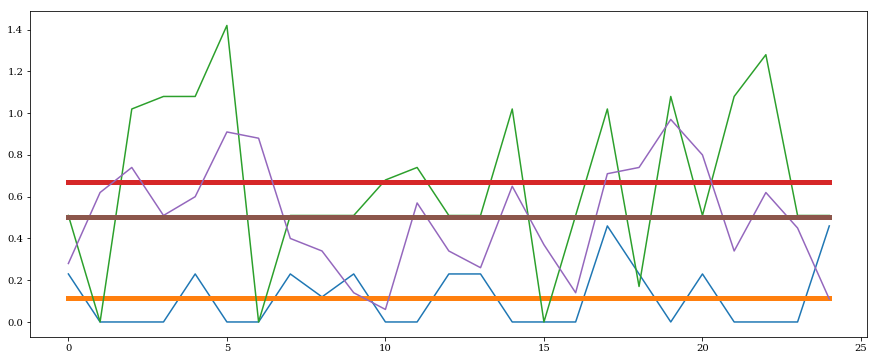

In [13]:
def get_errors(results, errors):
    for e,_,_ in results:
        errors.append(e)        

        
base_errors = []
get_errors(base_results, base_errors)

static_errors = []
get_errors(static_results, static_errors)

runtime_errors = []
get_errors(runtime_results, runtime_errors)


plt.figure(4, figsize=(15,6))
plt.plot(base_errors)
mean = np.mean(base_errors)
plt.plot([0, len(base_errors)-1], [mean, mean], linewidth=5)
plt.plot(static_errors)
mean = np.mean(static_errors)
plt.plot([0, len(static_errors)-1], [mean, mean], linewidth=5)
plt.plot(runtime_errors)
mean = np.mean(runtime_errors)
plt.plot([0, len(runtime_errors)-1], [mean, mean], linewidth=5)
plt.show()

In [15]:
def xp2(train_X, train_Y, test_X, test_Y, mode):
    results = []
    for i in range(0,N):
#         model = keras.models.load_model(base_dir + mode + str(i) + '_class_lstm.h5')
        model = keras_model(train_X[i].shape[2], train_Y[i].shape[2])
        train_start = datetime.datetime.now()
        model = train_and_save(model, train_X[i], train_Y[i], test_X[i], test_Y[i], mode, i, save=True)
        model.summary()
        train_stop = datetime.datetime.now()
        train_duration = train_stop - train_start
        for j in range(0,N):
            print('using model ', str(i), ' on data coming from ', str(j))
            print('-------------------------')
            predict_start = datetime.datetime.now()
            error_ratio = predict(model, test_X[j], test_Y[j])
            predict_stop = datetime.datetime.now()
            predict_duration = predict_stop - predict_start
            print(error_ratio, '% error')
            print('prediction duration = ', predict_duration)
            results.append((error_ratio, train_duration, predict_duration))
    return results

base_results_2 = xp2(base_X_train_supervised, base_Y_train_supervised, base_X_test_supervised, base_Y_test_supervised, 'base')
static_results_2 = xp2(static_X_train_supervised, static_Y_train_supervised, static_X_test_supervised, static_Y_test_supervised, 'static')
runtime_results_2 = xp2(runtime_X_train_supervised, runtime_Y_train_supervised, runtime_X_test_supervised, runtime_Y_test_supervised, 'runtime')            

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 10s 206ms/step - loss: 0.5964 - acc: 0.6925 - binary_accuracy: 0.6925 - val_loss: 0.5619 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 0s 9ms/step - loss: 0.5560 - acc: 0.7083 - binary_accuracy: 0.7083 - val_loss: 0.5481 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 3/100
49/49 [==============================] - 0s 9ms/step - loss: 0.4686 - acc: 0.7540 - binary_accuracy: 0.7540 - val_loss: 0.2202 - val_acc: 0.9167 - val_binary_accuracy: 0.9167
Epoch 4/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0821 - acc: 0.9739 - binary_accuracy: 0.9739 - val_loss: 0.0497 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 5/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0426 - acc: 0.9762 - binary_accuracy: 0.9762 - val_loss: 0.0355 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 6/100
49/49 [

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 11s 216ms/step - loss: 0.6079 - acc: 0.7072 - binary_accuracy: 0.7072 - val_loss: 0.5628 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 0s 9ms/step - loss: 0.5394 - acc: 0.7086 - binary_accuracy: 0.7086 - val_loss: 0.4854 - val_acc: 0.7153 - val_binary_accuracy: 0.7153
Epoch 3/100
49/49 [==============================] - 0s 9ms/step - loss: 0.1864 - acc: 0.9300 - binary_accuracy: 0.9300 - val_loss: 0.0531 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 4/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0363 - acc: 0.9810 - binary_accuracy: 0.9810 - val_loss: 0.0317 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 5/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0293 - acc: 0.9827 - binary_accuracy: 0.9827 - val_loss: 0.0291 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 6/100
49/49

2.08 % error
prediction duration =  0:00:00.005013
using model  1  on data coming from  12
-------------------------
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
2.08 % error
prediction duration =  0:00:00.007020
using model  1  on data coming from  13
-------------------------
0.0 % error
prediction duration =  0:00:00.005012
using model  1  on data coming from  14
-------------------------
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  

Epoch 4/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0576 - acc: 0.9782 - binary_accuracy: 0.9782 - val_loss: 0.0359 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 5/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0336 - acc: 0.9819 - binary_accuracy: 0.9819 - val_loss: 0.0330 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 6/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0287 - acc: 0.9813 - binary_accuracy: 0.9813 - val_loss: 0.0275 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 7/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0280 - acc: 0.9827 - binary_accuracy: 0.9827 - val_loss: 0.0276 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 8/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0253 - acc: 0.9870 - binary_accuracy: 0.9870 - val_loss: 0.0262 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 9/100
49/49 [==============================] - 0s 9ms/step

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
2.08 % error
prediction duration =  0:00:03.446484
using model  2  on data coming from  1
-------------------------
0.0 % error
prediction duration =  0:00:00.005044
using model  2  on data coming from  2
-------------------------
0.0 % error
prediction duration =  0:00:00.003979
using model  2  on data coming from  3
-------------------------
0.0 % error
prediction duration =  0:00:00.004011
using model  2  on data coming from  4
-------------------------
Predicting  ['m2'

49/49 [==============================] - 11s 229ms/step - loss: 0.6243 - acc: 0.6443 - binary_accuracy: 0.6443 - val_loss: 0.5623 - val_acc: 0.7037 - val_binary_accuracy: 0.7037
Epoch 2/100
49/49 [==============================] - 0s 9ms/step - loss: 0.5168 - acc: 0.7248 - binary_accuracy: 0.7248 - val_loss: 0.3537 - val_acc: 0.8912 - val_binary_accuracy: 0.8912
Epoch 3/100
49/49 [==============================] - 0s 9ms/step - loss: 0.1351 - acc: 0.9685 - binary_accuracy: 0.9685 - val_loss: 0.0435 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 4/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0395 - acc: 0.9796 - binary_accuracy: 0.9796 - val_loss: 0.0298 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 5/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0285 - acc: 0.9864 - binary_accuracy: 0.9864 - val_loss: 0.0242 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 6/100
49/49 [==============================] - 0s 9ms/step - loss: 0

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
2.55 % error
prediction duration =  0:00:00.005013
using model  3  on data coming from  18
-------------------------
0.0 % error
prediction duration =  0:00:00.005014
using model  3  on data coming from  19
-------------------------
0.0 % error
prediction duration =  0:00:00.004010
using model  3  on data coming from  20
-------------------------
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c

49/49 [==============================] - 0s 9ms/step - loss: 0.0086 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0031 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 29/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0081 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0027 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 30/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0086 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0018 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 31/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0089 - acc: 0.9963 - binary_accuracy: 0.9963 - val_loss: 0.0023 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 32/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0069 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0069 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 33/100
49/49 [==============================] - 0s 9ms/step - loss:

Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
0.69 % error
prediction duration =  0:00:00.004987
using model  4  on data coming from  22
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
0.46 % error
prediction duration =  0:00:00.005014
using model  4  on data coming from  23
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
0.69 % error
prediction duration =  0:00:00.005013
using model  4  on data coming from  24
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
0.46 % error
prediction duration =  0:00:00.005045
Train on 49 sample

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 11s 232ms/step - loss: 0.6005 - acc: 0.6981 - binary_accuracy: 0.6981 - val_loss: 0.5621 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 0s 10ms/step - loss: 0.5475 - acc: 0.7083 - binary_accuracy: 0.7083 - val_loss: 0.5155 - val_acc: 0.7106 - val_binary_accuracy: 0.7106
Epoch 3/100
49/49 [==============================] - 0s 9ms/step - loss: 0.3293 - acc: 0.8520 - binary_accuracy: 0.8520 - val_loss: 0.0850 - val_acc: 0.9722 - val_binary_accuracy: 0.9722
Epoch 4/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0514 - acc: 0.9793 - binary_accuracy: 0.9793 - val_loss: 0.0331 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 5/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0324 - acc: 0.9804 - binary_accuracy: 0.9804 - val_loss: 0.0287 - val_acc: 0.9722 - val_binary_accuracy: 0.9722
Epoch 6/100
49/49 

0.0 % error
prediction duration =  0:00:03.211941
using model  6  on data coming from  1
-------------------------
Predicting  ['m2', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
0.46 % error
prediction duration =  0:00:00.005013
using model  6  on data coming from  2
-------------------------
Predicting  ['m3', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
0.12 % error
prediction duration =  0:00:00.005044
using model  6  on data coming from  3
-------------------------
Predicting  ['m3', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
0.12 % error
prediction duration =  0:00:00.005009
using model  6  on data coming from  4
-------------------------
0.0 % error
prediction duration =  0:00:00.003983
using model  6  on data coming from  5
-------------------------
0.0 % error
prediction duration =  0:00:00.005013
us

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 11s 232ms/step - loss: 0.6060 - acc: 0.6905 - binary_accuracy: 0.6905 - val_loss: 0.5629 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 0s 10ms/step - loss: 0.5549 - acc: 0.7083 - binary_accuracy: 0.7083 - val_loss: 0.5441 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 3/100
49/49 [==============================] - 0s 9ms/step - loss: 0.4352 - acc: 0.7727 - binary_accuracy: 0.7727 - val_loss: 0.1253 - val_acc: 0.9676 - val_binary_accuracy: 0.9676
Epoch 4/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0629 - acc: 0.9799 - binary_accuracy: 0.9799 - val_loss: 0.0374 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 5/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0374 - acc: 0.9799 - binary_accuracy: 0.9799 - val_loss: 0.0304 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 6/100
49/49 

Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'a', 'b', 'c']
0.29 % error
prediction duration =  0:00:03.221545
using model  8  on data coming from  1
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
0.46 % error
prediction duration =  0:00:00.004983
using model  8  on data coming from  2
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
0.46 % error
prediction duration =  0:00:00.004008
using model  8  on data coming from  3
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
0.23 % error
prediction duration =  0:00:00.004009
using model  8  on data coming from  4
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
0.23 % error
prediction duration =  0:00:00.004984
using model  8  

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 12s 248ms/step - loss: 0.6052 - acc: 0.6993 - binary_accuracy: 0.6993 - val_loss: 0.5620 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 0s 9ms/step - loss: 0.5475 - acc: 0.7083 - binary_accuracy: 0.7083 - val_loss: 0.5135 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 3/100
49/49 [==============================] - 0s 9ms/step - loss: 0.2723 - acc: 0.8776 - binary_accuracy: 0.8776 - val_loss: 0.0629 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 4/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0431 - acc: 0.9819 - binary_accuracy: 0.9819 - val_loss: 0.0353 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 5/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0311 - acc: 0.9819 - binary_accuracy: 0.9819 - val_loss: 0.0298 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 6/100
49/49 [

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
1.16 % error
prediction duration =  0:00:03.660851
using model  10  on data coming from  1
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
0.46 % error
prediction duration =  0:00:00.005014
using model  10  on data coming from  2
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
0.46 % error
prediction duration =  0:00:00.005013
using model  10  on data coming from  3
-------------------------
Predicting  ['m3', 'a'] . T

49/49 [==============================] - 0s 9ms/step - loss: 0.0114 - acc: 0.9974 - binary_accuracy: 0.9974 - val_loss: 0.0080 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 18/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0117 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0071 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 19/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0105 - acc: 0.9972 - binary_accuracy: 0.9972 - val_loss: 0.0083 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 20/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0116 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0077 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 21/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0083 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0040 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 22/100
49/49 [==============================] - 0s 9ms/step - loss:

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 12s 245ms/step - loss: 0.6039 - acc: 0.7012 - binary_accuracy: 0.7012 - val_loss: 0.5616 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 0s 9ms/step - loss: 0.5422 - acc: 0.7086 - binary_accuracy: 0.7086 - val_loss: 0.4965 - val_acc: 0.7130 - val_binary_accuracy: 0.7130
Epoch 3/100
49/49 [==============================] - 0s 9ms/step - loss: 0.2561 - acc: 0.8948 - binary_accuracy: 0.8948 - val_loss: 0.0548 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 4/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0409 - acc: 0.9776 - binary_accuracy: 0.9776 - val_loss: 0.0317 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 5/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0302 - acc: 0.9796 - binary_accuracy: 0.9796 - val_loss: 0.0280 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 6/100
49/49 [

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 13s 258ms/step - loss: 0.6121 - acc: 0.6857 - binary_accuracy: 0.6857 - val_loss: 0.5601 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 1s 10ms/step - loss: 0.5355 - acc: 0.7092 - binary_accuracy: 0.7092 - val_loss: 0.4655 - val_acc: 0.7338 - val_binary_accuracy: 0.7338
Epoch 3/100
49/49 [==============================] - 1s 10ms/step - loss: 0.2332 - acc: 0.9147 - binary_accuracy: 0.9147 - val_loss: 0.0548 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 4/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0417 - acc: 0.9796 - binary_accuracy: 0.9796 - val_loss: 0.0314 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 5/100
49/49 [==============================] - 1s 10ms/step - loss: 0.0317 - acc: 0.9779 - binary_accuracy: 0.9779 - val_loss: 0.0288 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 6/100
49/

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
2.2 % error
prediction duration =  0:00:03.821587
using model  13  on data coming from  1
-------------------------
0.0 % error
prediction duration =  0:00:00.005045
using model  13  on data coming from  2
-------------------------
Predicting  ['m3', 'a'] . Tr

Epoch 7/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0287 - acc: 0.9799 - binary_accuracy: 0.9799 - val_loss: 0.0266 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 8/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0271 - acc: 0.9847 - binary_accuracy: 0.9847 - val_loss: 0.0249 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 9/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0318 - acc: 0.9827 - binary_accuracy: 0.9827 - val_loss: 0.0247 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 10/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0270 - acc: 0.9887 - binary_accuracy: 0.9887 - val_loss: 0.0227 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 11/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0252 - acc: 0.9861 - binary_accuracy: 0.9861 - val_loss: 0.0226 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 12/100
49/49 [==============================] - 0s 9ms/s

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 14s 277ms/step - loss: 0.5973 - acc: 0.6922 - binary_accuracy: 0.6922 - val_loss: 0.5598 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 0s 10ms/step - loss: 0.5528 - acc: 0.7083 - binary_accuracy: 0.7083 - val_loss: 0.5352 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 3/100
49/49 [==============================] - 0s 10ms/step - loss: 0.3941 - acc: 0.8027 - binary_accuracy: 0.8027 - val_loss: 0.1115 - val_acc: 0.9722 - val_binary_accuracy: 0.9722
Epoch 4/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0646 - acc: 0.9830 - binary_accuracy: 0.9830 - val_loss: 0.0370 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 5/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0347 - acc: 0.9819 - binary_accuracy: 0.9819 - val_loss: 0.0285 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 6/100
49/4

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 13s 259ms/step - loss: 0.6120 - acc: 0.7001 - binary_accuracy: 0.7001 - val_loss: 0.5659 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 0s 9ms/step - loss: 0.5545 - acc: 0.7083 - binary_accuracy: 0.7083 - val_loss: 0.5352 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 3/100
49/49 [==============================] - 0s 9ms/step - loss: 0.3480 - acc: 0.8379 - binary_accuracy: 0.8379 - val_loss: 0.0865 - val_acc: 0.9676 - val_binary_accuracy: 0.9676
Epoch 4/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0476 - acc: 0.9830 - binary_accuracy: 0.9830 - val_loss: 0.0320 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 5/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0299 - acc: 0.9838 - binary_accuracy: 0.9838 - val_loss: 0.0298 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 6/100
49/49 [

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
2.08 % error
prediction duration =  0:00:00.006015
using model  16  on data coming from  13
-------------------------
0.0 % error
prediction duration =  0:00:00.005040
using model  16  on data coming from  14
-------------------------
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
2.08 % error
prediction duration =  0:00:00.005989
using model  16  on data coming from  15
-------------------------
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predictin

Predicting  ['m3', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
0.87 % error
prediction duration =  0:00:00.005988
using model  17  on data coming from  18
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
0.46 % error
prediction duration =  0:00:00.005014
using model  17  on data coming from  19
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
1.16 % error
prediction duration =  0:00:00.005013
using model  17  on data coming from  20
-------------------------
Pre

Epoch 3/100
49/49 [==============================] - 0s 9ms/step - loss: 0.1656 - acc: 0.9456 - binary_accuracy: 0.9456 - val_loss: 0.0483 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 4/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0360 - acc: 0.9858 - binary_accuracy: 0.9858 - val_loss: 0.0364 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 5/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0296 - acc: 0.9867 - binary_accuracy: 0.9867 - val_loss: 0.0282 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 6/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0278 - acc: 0.9813 - binary_accuracy: 0.9813 - val_loss: 0.0265 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 7/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0250 - acc: 0.9872 - binary_accuracy: 0.9872 - val_loss: 0.0227 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 8/100
49/49 [==============================] - 0s 10ms/ste

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 14s 276ms/step - loss: 0.6036 - acc: 0.6837 - binary_accuracy: 0.6837 - val_loss: 0.5627 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 0s 10ms/step - loss: 0.5544 - acc: 0.7083 - binary_accuracy: 0.7083 - val_loss: 0.5419 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 3/100
49/49 [==============================] - 0s 10ms/step - loss: 0.4654 - acc: 0.7588 - binary_accuracy: 0.7588 - val_loss: 0.2371 - val_acc: 0.9398 - val_binary_accuracy: 0.9398
Epoch 4/100
49/49 [==============================] - 0s 9ms/step - loss: 0.1006 - acc: 0.9717 - binary_accuracy: 0.9717 - val_loss: 0.0396 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 5/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0372 - acc: 0.9836 - binary_accuracy: 0.9836 - val_loss: 0.0285 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 6/100
49/49

Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
0.69 % error
prediction duration =  0:00:04.153202
using model  20  on data coming from  1
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
1.04 % error
prediction duration =  0:00:00.005013
using model  20  on data coming from  2
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
0.93 % error
prediction duration =  0:00:00.005015
using mod

Epoch 9/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0246 - acc: 0.9867 - binary_accuracy: 0.9867 - val_loss: 0.0229 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 10/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0200 - acc: 0.9929 - binary_accuracy: 0.9929 - val_loss: 0.0210 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 11/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0210 - acc: 0.9906 - binary_accuracy: 0.9906 - val_loss: 0.0319 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 12/100
49/49 [==============================] - 1s 10ms/step - loss: 0.0216 - acc: 0.9875 - binary_accuracy: 0.9875 - val_loss: 0.0196 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 13/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0164 - acc: 0.9915 - binary_accuracy: 0.9915 - val_loss: 0.0188 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 14/100
49/49 [==============================] - 0s 9

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 14s 295ms/step - loss: 0.6113 - acc: 0.6780 - binary_accuracy: 0.6780 - val_loss: 0.5622 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 0s 9ms/step - loss: 0.5492 - acc: 0.7083 - binary_accuracy: 0.7083 - val_loss: 0.5191 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 3/100
49/49 [==============================] - 0s 9ms/step - loss: 0.2958 - acc: 0.8773 - binary_accuracy: 0.8773 - val_loss: 0.0707 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 4/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0473 - acc: 0.9799 - binary_accuracy: 0.9799 - val_loss: 0.0359 - val_acc: 0.9676 - val_binary_accuracy: 0.9676
Epoch 5/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0341 - acc: 0.9765 - binary_accuracy: 0.9765 - val_loss: 0.0298 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 6/100
49/49 

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
2.08 % error
prediction duration =  0:00:04.362596
using model  22  on data coming from  1
-------------------------
Predicting  ['m3', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
0.12 % error
prediction duration =  0:00:00.006026
using model  22  on data coming from  2
-------------------------
Predicting  ['m3', 'a', 'b'] . Truth is  ['m2', 'a', 'b', 'c']
0.17 % error
prediction duration =  0:00:00.005036
using model  22  on data coming from  3
----------------------

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 15s 311ms/step - loss: 0.6016 - acc: 0.7027 - binary_accuracy: 0.7027 - val_loss: 0.5619 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 0s 10ms/step - loss: 0.5537 - acc: 0.7083 - binary_accuracy: 0.7083 - val_loss: 0.5377 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 3/100
49/49 [==============================] - 0s 10ms/step - loss: 0.3912 - acc: 0.8126 - binary_accuracy: 0.8126 - val_loss: 0.1082 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 4/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0596 - acc: 0.9773 - binary_accuracy: 0.9773 - val_loss: 0.0378 - val_acc: 0.9769 - val_binary_accuracy: 0.9769
Epoch 5/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0354 - acc: 0.9816 - binary_accuracy: 0.9816 - val_loss: 0.0352 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 6/100
49/

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
2.08 % error
prediction duration =  0:00:04.570328
using model  24  on data coming from  1
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
0.23 % error
prediction duration =  0:00:00.005012
using model  24  on data coming from  2
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
0.23 % error
prediction duration =  0:00:00.005013
using model  24  on data coming from  3
-------------------------
Predicting 

99/99 [==============================] - 1s 10ms/step - loss: 0.0041 - acc: 0.9982 - binary_accuracy: 0.9982 - val_loss: 0.0034 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 54/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0036 - acc: 0.9986 - binary_accuracy: 0.9986 - val_loss: 0.0114 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 55/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0042 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0040 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 56/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0033 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0072 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 00056: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_200 (TimeDi (None, 9, 250)            3500      
_______________________________

Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2']
5.99 % error
prediction duration =  0:00:00.014037
using model  0  on data coming from  5
-------------------------
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3', '

Predicting  ['m1', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'd'] . Tru

Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a'

99/99 [==============================] - 16s 162ms/step - loss: 0.5816 - acc: 0.7160 - binary_accuracy: 0.7160 - val_loss: 0.3568 - val_acc: 0.8160 - val_binary_accuracy: 0.8160
Epoch 2/100
99/99 [==============================] - 1s 10ms/step - loss: 0.1323 - acc: 0.9575 - binary_accuracy: 0.9575 - val_loss: 0.0593 - val_acc: 0.9769 - val_binary_accuracy: 0.9769
Epoch 3/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0557 - acc: 0.9747 - binary_accuracy: 0.9747 - val_loss: 0.0457 - val_acc: 0.9792 - val_binary_accuracy: 0.9792
Epoch 4/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0398 - acc: 0.9798 - binary_accuracy: 0.9798 - val_loss: 0.0420 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 5/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0317 - acc: 0.9858 - binary_accuracy: 0.9858 - val_loss: 0.0259 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 6/100
99/99 [==============================] - 1s 10ms/step - lo

Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'd'] . Tru

Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predi

Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m2', 'c']
4.97 % error
prediction duration =  0:00:00.073184
using model  1  on data coming from  19
-------------------------
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'c', 'd'] . 

Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
5.74 % error
prediction duration =  0:00:00.067176
using model  1  on data coming from  24
-------------------------
Predicting  ['m1', 'b', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m2', 'a', 'b'

Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Pr

Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
4.43 % error
prediction duration =  0:00:00.069822
using model  2  on data coming from  15
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predict

Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m

Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting

Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting 

Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
2.61 % error
prediction duration =  0:00:00.012534
using model  3  on data coming from  23
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m1', 'e']
Predicting  ['m2', '

Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m1'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m1'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'c

Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2'] . Tr

Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
3.01 % error
prediction duration =  0:00:00.012997
using model  4  on data coming from  22
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . T

Epoch 3/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0509 - acc: 0.9756 - binary_accuracy: 0.9756 - val_loss: 0.0414 - val_acc: 0.9769 - val_binary_accuracy: 0.9769
Epoch 4/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0414 - acc: 0.9766 - binary_accuracy: 0.9766 - val_loss: 0.0379 - val_acc: 0.9780 - val_binary_accuracy: 0.9780
Epoch 5/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0389 - acc: 0.9760 - binary_accuracy: 0.9760 - val_loss: 0.0367 - val_acc: 0.9792 - val_binary_accuracy: 0.9792
Epoch 6/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0373 - acc: 0.9795 - binary_accuracy: 0.9795 - val_loss: 0.0362 - val_acc: 0.9780 - val_binary_accuracy: 0.9780
Epoch 7/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0381 - acc: 0.9773 - binary_accuracy: 0.9773 - val_loss: 0.0405 - val_acc: 0.9792 - val_binary_accuracy: 0.9792
Epoch 8/100
99/99 [==============================] - 1s 10ms

-------------------------
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3', 'a', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'a', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3', 'a', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'a', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3', 'a', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'a', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3', 'a', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'a', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd

Predicting  ['m1', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'c', 'd', 'e

Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a'

99/99 [==============================] - 17s 174ms/step - loss: 0.4454 - acc: 0.7793 - binary_accuracy: 0.7793 - val_loss: 0.1009 - val_acc: 0.9745 - val_binary_accuracy: 0.9745
Epoch 2/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0457 - acc: 0.9846 - binary_accuracy: 0.9846 - val_loss: 0.0267 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 3/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0255 - acc: 0.9895 - binary_accuracy: 0.9895 - val_loss: 0.0312 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 4/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0251 - acc: 0.9882 - binary_accuracy: 0.9882 - val_loss: 0.0246 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 5/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0233 - acc: 0.9881 - binary_accuracy: 0.9881 - val_loss: 0.0190 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 6/100
99/99 [==============================] - 1s 10ms/step - lo

Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Tr

Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'c'] . Tru

Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m1']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m1']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m1']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'd

99/99 [==============================] - 18s 177ms/step - loss: 0.6058 - acc: 0.6961 - binary_accuracy: 0.6961 - val_loss: 0.5445 - val_acc: 0.7523 - val_binary_accuracy: 0.7523
Epoch 2/100
99/99 [==============================] - 1s 10ms/step - loss: 0.2312 - acc: 0.9063 - binary_accuracy: 0.9063 - val_loss: 0.0833 - val_acc: 0.9699 - val_binary_accuracy: 0.9699
Epoch 3/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0473 - acc: 0.9832 - binary_accuracy: 0.9832 - val_loss: 0.0354 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 4/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0302 - acc: 0.9886 - binary_accuracy: 0.9886 - val_loss: 0.0280 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 5/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0251 - acc: 0.9898 - binary_accuracy: 0.9898 - val_loss: 0.0234 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 6/100
99/99 [==============================] - 1s 10ms/step - lo

using model  7  on data coming from  4
-------------------------
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] 

Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m3', 'a', 'd', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth

Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Pre

Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', '

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
6.96 % error
prediction duration =  0:00:00.0686

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1',

Epoch 3/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0235 - acc: 0.9910 - binary_accuracy: 0.9910 - val_loss: 0.0197 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 4/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0176 - acc: 0.9926 - binary_accuracy: 0.9926 - val_loss: 0.0146 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 5/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0124 - acc: 0.9959 - binary_accuracy: 0.9959 - val_loss: 0.0107 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 6/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0102 - acc: 0.9951 - binary_accuracy: 0.9951 - val_loss: 0.0092 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 7/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0088 - acc: 0.9949 - binary_accuracy: 0.9949 - val_loss: 0.0090 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 8/100
99/99 [==============================] - 1s 9ms/step

Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predictin

Predicting  ['m1', 'a'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'b', 'c', 

Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'a']
5.8 % error
prediction duration =  0:00:00.013034
using model  9  on data coming from  23
-------------------------
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3'] . Truth is

Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Pred

Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m1'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m1', 'b', 'd'] . Truth 

Predicting  ['m1', 'a', 'b'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m3',

Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'c', 'e'] 

Epoch 13/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0320 - acc: 0.9823 - binary_accuracy: 0.9823 - val_loss: 0.0324 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 14/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0316 - acc: 0.9805 - binary_accuracy: 0.9805 - val_loss: 0.0312 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 15/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0295 - acc: 0.9827 - binary_accuracy: 0.9827 - val_loss: 0.0309 - val_acc: 0.9792 - val_binary_accuracy: 0.9792
Epoch 16/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0311 - acc: 0.9805 - binary_accuracy: 0.9805 - val_loss: 0.0307 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 17/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0286 - acc: 0.9812 - binary_accuracy: 0.9812 - val_loss: 0.0288 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 18/100
99/99 [==============================] - 1

Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c'

Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'b'] . Truth is  ['m2', 'b', 'c']
3.98 % error
prediction duration =  0:00:00.066049
using model  11  on data coming from  16
-------------------------
Predicting  ['m1', 'b'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b'] . Truth is

Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b'] . Truth is  ['m2']
Predicting  ['m1', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'b'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b'] . Truth is  ['m2']
3.41 % error
prediction duration =  0:00:00.014005
using model  11  on data coming from  22
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a

99/99 [==============================] - 1s 12ms/step - loss: 0.0073 - acc: 0.9958 - binary_accuracy: 0.9958 - val_loss: 0.0073 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 48/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0102 - acc: 0.9944 - binary_accuracy: 0.9944 - val_loss: 0.0446 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 49/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0580 - acc: 0.9851 - binary_accuracy: 0.9851 - val_loss: 0.0090 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 50/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0087 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0079 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 51/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0079 - acc: 0.9945 - binary_accuracy: 0.9945 - val_loss: 0.0074 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 52/100
99/99 [==============================] - 1s 12ms/step -

Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1']
Predicting  ['m2

Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3

Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2']
4.69 % error
prediction duration =  0:00:00.077510
using model  12  on data coming from  22
-------------------------
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . T

Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 20s 203ms/step - loss: 0.3739 - acc: 0.8259 - binary_accuracy: 0.8259 - val_loss: 0.0426 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 2/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0271 - acc: 0.9902 - binary_accuracy: 0.9902 - val_loss: 0.0217 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 3/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0218 - acc: 0.9900 - binary_accuracy: 0.9900 - val_loss: 0.0190 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 4/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0200 - acc: 0.9899 - binary_accuracy: 0.9899 - val_loss: 0.0197 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 5/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0200 - acc: 0.9895 - binary_accuracy: 0.9895 - val_loss: 0.0181 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 6/100
99

Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m

Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'b', 'c']
3.86 % error
prediction duration =  0:00:00.075202
using model  13  on data coming from  12
-------------------------
Pre

Predicting  ['m1', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1

Predicting  ['m1'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
5.2 % error
prediction duration =  0:00:00.072189
Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 21s 212ms/step - loss: 0.4334 - acc: 0.7966 - binary_accuracy: 0.7966 - val_loss: 0.0719 - val_acc: 0.9769 - val_binary_accuracy: 0.9769
Epoch 2/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0514 - acc: 0.9776 - binary_accuracy: 0.9776 - val_loss: 0.035

Epoch 41/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0071 - acc: 0.9949 - binary_accuracy: 0.9949 - val_loss: 0.0067 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 42/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0072 - acc: 0.9937 - binary_accuracy: 0.9937 - val_loss: 0.0066 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 43/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0073 - acc: 0.9944 - binary_accuracy: 0.9944 - val_loss: 0.0066 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 44/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0069 - acc: 0.9955 - binary_accuracy: 0.9955 - val_loss: 0.0066 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 45/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0070 - acc: 0.9940 - binary_accuracy: 0.9940 - val_loss: 0.0065 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 46/100
99/99 [==============================] - 1

Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m1', 'b'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m1', 'b'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Pred

Predicting  ['m3', 'a'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  

Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'a', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'a', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'a', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'a', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
3.3 % error
prediction duration =  0:00:00.

99/99 [==============================] - 18s 179ms/step - loss: 0.5687 - acc: 0.7128 - binary_accuracy: 0.7128 - val_loss: 0.3509 - val_acc: 0.8310 - val_binary_accuracy: 0.8310
Epoch 2/100
99/99 [==============================] - 1s 10ms/step - loss: 0.1513 - acc: 0.9404 - binary_accuracy: 0.9404 - val_loss: 0.0850 - val_acc: 0.9549 - val_binary_accuracy: 0.9549
Epoch 3/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0657 - acc: 0.9708 - binary_accuracy: 0.9708 - val_loss: 0.0502 - val_acc: 0.9803 - val_binary_accuracy: 0.9803
Epoch 4/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0473 - acc: 0.9769 - binary_accuracy: 0.9769 - val_loss: 0.0415 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 5/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0396 - acc: 0.9809 - binary_accuracy: 0.9809 - val_loss: 0.0359 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 6/100
99/99 [==============================] - 1s 10ms/step - lo

Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1'

Predicting  ['m1', 'a'] . Truth is  ['m2']
Predicting  ['m1', 'a'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a'] . Truth is  ['m1']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a'] . Truth is  ['m2']
Predicting  ['m1', 'a'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a'] . Truth is  ['m1']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a'] . Truth is  ['m2']
Predicting  ['m1', 'a'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a'] . Truth is  ['m1']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a'] . Truth is  ['m2']
Predicting  ['m1',

Predicting  ['m1', 'a', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'e'] . 

Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e'

Predicting  ['m2', 'a', 'e'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'e'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'e'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1',

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m1', 'b']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m1', 'b']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m1', 'b']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2']

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
6.22 % error
prediction duration =  0:00:00.051150
using model  17  on data coming from  5
----------------

Predicting  ['m2', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c', 'd'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c', 'd'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c', 'd'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'b']
Predicting  

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a'

99/99 [==============================] - 19s 194ms/step - loss: 0.3658 - acc: 0.8342 - binary_accuracy: 0.8342 - val_loss: 0.0536 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 2/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0380 - acc: 0.9844 - binary_accuracy: 0.9844 - val_loss: 0.0322 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 3/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0305 - acc: 0.9867 - binary_accuracy: 0.9867 - val_loss: 0.0279 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 4/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0272 - acc: 0.9868 - binary_accuracy: 0.9868 - val_loss: 0.0259 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 5/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0247 - acc: 0.9889 - binary_accuracy: 0.9889 - val_loss: 0.0230 - val_acc: 0.9850 - val_binary_accuracy: 0.9850
Epoch 6/100
99/99 [==============================] - 1s 11ms/step - lo

Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'c'] . 

Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
3.81 % error
prediction duration =  0:00:00.080214
using model  18  on data coming from  13
-------------------------
Predicting  ['m1', 'a', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
P

Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a']
4.55 % error
prediction duration =  0:00:00.014037
using model  18  on data coming from  23
-------------------------
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  

Predicting  ['m1'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m1'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b'

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m1', 'b']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m1', 'b']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m1', 'b']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m2

Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3'] . Truth is

Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3

Predicting  ['m2'] . Truth is  ['m1']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m1']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m1']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b', 'c']
4.38 % error
prediction duration =  0:00:00.066150
using model  20  on data coming from  18
-------------------------
Predicting  ['m1', 'e'] . Truth is  ['m2', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'c']
Predicting  ['m2']

Predicting  ['m1', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
4.6 % error
prediction duration =  0:00:00.013535
Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 19s 193ms/step - loss: 0.3540 - acc: 0.8455 - binary_accuracy: 0.8455 - val_loss: 0.0453 - val_acc: 0.9907 - val_binary_accuracy:

Predicting  ['m2'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m2'] .

Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'c']
4.97 % error
prediction duration =  0:00:00.068154
using model  21  on data coming from  15
-------------------------
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m3', 

Predicting  ['m1'] . Truth is  ['m1', 'b']
Predicting  ['m1'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1'] . Truth is  ['m1', 'b']
Predicting  ['m1'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1'] . Truth is  ['m1', 'b']
Predicting  ['m1'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1'] . Truth is  ['m1', 'b']
Predicting  ['m1'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'a']
Pr

Epoch 4/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0323 - acc: 0.9837 - binary_accuracy: 0.9837 - val_loss: 0.0320 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 5/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0316 - acc: 0.9833 - binary_accuracy: 0.9833 - val_loss: 0.0315 - val_acc: 0.9850 - val_binary_accuracy: 0.9850
Epoch 6/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0297 - acc: 0.9841 - binary_accuracy: 0.9841 - val_loss: 0.0307 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 7/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0301 - acc: 0.9836 - binary_accuracy: 0.9836 - val_loss: 0.0295 - val_acc: 0.9850 - val_binary_accuracy: 0.9850
Epoch 8/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0309 - acc: 0.9832 - binary_accuracy: 0.9832 - val_loss: 0.0282 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 9/100
99/99 [==============================] - 1s 11ms

99/99 [==============================] - 1s 11ms/step - loss: 0.0151 - acc: 0.9920 - binary_accuracy: 0.9920 - val_loss: 0.0123 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 91/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0114 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0084 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 92/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0152 - acc: 0.9933 - binary_accuracy: 0.9933 - val_loss: 0.0101 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 93/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0100 - acc: 0.9951 - binary_accuracy: 0.9951 - val_loss: 0.0080 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 94/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0103 - acc: 0.9951 - binary_accuracy: 0.9951 - val_loss: 0.0128 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 95/100
99/99 [==============================] - 1s 11ms/step -

Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2']
P

Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
5.4 % error
prediction duration =  0:00:00.070184
using model  22  on data coming from  13
-------------------------
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2',

Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m3', 'a

99/99 [==============================] - 1s 11ms/step - loss: 0.0072 - acc: 0.9955 - binary_accuracy: 0.9955 - val_loss: 0.0102 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 00044: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_246 (TimeDi (None, 9, 250)            3500      
_________________________________________________________________
cu_dnnlstm_123 (CuDNNLSTM)   (None, 9, 125)            188500    
_________________________________________________________________
time_distributed_247 (TimeDi (None, 9, 50)             6300      
_________________________________________________________________
dense_371 (Dense)            (None, 9, 8)              408       
Total params: 198,708
Trainable params: 198,708
Non-trainable params: 0
_________________________________________________________________
using model  23  on data coming from  0
------------------------

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'e'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'e'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'e'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'e'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'e'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'e'] . Tru

Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  

Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
4.15 % error
prediction duration =  0:00:00.014004
using model  23  on data coming from  20
-------------------------
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'e']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predic

99/99 [==============================] - 20s 198ms/step - loss: 0.3408 - acc: 0.8565 - binary_accuracy: 0.8565 - val_loss: 0.0331 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 2/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0245 - acc: 0.9905 - binary_accuracy: 0.9905 - val_loss: 0.0197 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 3/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0201 - acc: 0.9898 - binary_accuracy: 0.9898 - val_loss: 0.0191 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 4/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0181 - acc: 0.9905 - binary_accuracy: 0.9905 - val_loss: 0.0168 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 5/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0174 - acc: 0.9912 - binary_accuracy: 0.9912 - val_loss: 0.0163 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 6/100
99/99 [==============================] - 1s 11ms/step - lo

Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
3.32 % error
prediction duration =  0:00:00.045120
using model  24  on data coming from  5
-------------------------
Predicting  ['m1', 'a', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m

Predicting  ['m1', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'b']
Predicting  ['m1

Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
4.4 % error
prediction duration =  0:00:00.013037
using model  24  on data coming from  21
-------------------------
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']

99/99 [==============================] - 1s 11ms/step - loss: 0.0068 - acc: 0.9980 - binary_accuracy: 0.9980 - val_loss: 0.0278 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 49/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0117 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0101 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 50/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0083 - acc: 0.9972 - binary_accuracy: 0.9972 - val_loss: 0.0126 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 51/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0068 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0142 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 52/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0053 - acc: 0.9983 - binary_accuracy: 0.9983 - val_loss: 0.0093 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 53/100
99/99 [==============================] - 1s 10ms/step -

Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2']
Predicting  ['m

Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
4.15 % error
prediction duration =  0:00:00.063168
using model  0  on data coming from  15
-------------------------
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'd', 'e']
Predicting

Predicting  ['m3'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'c']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'c']
4.46 % error
prediction duration =  0:00:00.014038
using model  0  on data coming from  23
------------

Epoch 18/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0373 - acc: 0.9829 - binary_accuracy: 0.9829 - val_loss: 0.0204 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 19/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0361 - acc: 0.9832 - binary_accuracy: 0.9832 - val_loss: 0.0166 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 20/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0337 - acc: 0.9844 - binary_accuracy: 0.9844 - val_loss: 0.0192 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 21/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0364 - acc: 0.9836 - binary_accuracy: 0.9836 - val_loss: 0.0159 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 22/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0325 - acc: 0.9851 - binary_accuracy: 0.9851 - val_loss: 0.0153 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 23/100
99/99 [==============================] - 1

Predicting  ['m1', 'd'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'd'] . Truth is  ['m2']
Predicting  ['m1', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'd'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'd'] . Truth is  ['m2']
Predicting  ['m1', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'd'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'd'] . Truth is  ['m2']
Predicting  ['m1', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'd'] . Truth is  ['m1', 'b'

Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
4.94 % error
prediction duration =  0:00:00.064163
using model  1  on data coming from  15
-------------------------
Predicting  ['m2'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'd'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'd'] . Truth is  ['m3', 'a']
Predictin

Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'c']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'c']
4.29 % error
prediction duration =  0:00:00.015010
using model  1  on data coming from  23
-------------------------
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'd'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'e']
Predictin

Epoch 14/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0401 - acc: 0.9820 - binary_accuracy: 0.9820 - val_loss: 0.0441 - val_acc: 0.9699 - val_binary_accuracy: 0.9699
Epoch 15/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0394 - acc: 0.9816 - binary_accuracy: 0.9816 - val_loss: 0.0388 - val_acc: 0.9826 - val_binary_accuracy: 0.9826
Epoch 16/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0385 - acc: 0.9830 - binary_accuracy: 0.9830 - val_loss: 0.0322 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 17/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0353 - acc: 0.9834 - binary_accuracy: 0.9834 - val_loss: 0.0288 - val_acc: 0.9850 - val_binary_accuracy: 0.9850
Epoch 18/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0342 - acc: 0.9825 - binary_accuracy: 0.9825 - val_loss: 0.0365 - val_acc: 0.9699 - val_binary_accuracy: 0.9699
Epoch 19/100
99/99 [==============================] - 1

Predicting  ['m1', 'd'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'd'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'd'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'd'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'd'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'd'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth i

Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b

Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'b', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'b', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2']
4.52 % error
prediction duration =  0:00:00.073195
using model  2  on data coming from  12
-------------------------
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'd'] . Truth is  ['m3'

Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'c']
6.11 % error
prediction duration =  0:00:00.016043
using model  2  on data coming from  20
-------------------------
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'c', 'd']
Predicting  ['m1', 'a', '

Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 20s 200ms/step - loss: 0.6144 - acc: 0.6876 - binary_accuracy: 0.6876 - val_loss: 0.5708 - val_acc: 0.7072 - val_binary_accuracy: 0.7072
Epoch 2/100
99/99 [==============================] - 1s 10ms/step - loss: 0.4233 - acc: 0.7994 - binary_accuracy: 0.7994 - val_loss: 0.3580 - val_acc: 0.8530 - val_binary_accuracy: 0.8530
Epoch 3/100
99/99 [==============================] - 1s 10ms/step - loss: 0.2627 - acc: 0.9060 - binary_accuracy: 0.9060 - val_loss: 0.2593 - val_acc: 0.8738 - val_binary_accuracy: 0.8738
Epoch 4/100
99/99 [==============================] - 1s 10ms/step - loss: 0.1913 - acc: 0.9275 - binary_accuracy: 0.9275 - val_loss: 0.1896 - val_acc: 0.9016 - val_binary_accuracy: 0.9016
Epoch 5/100
99/99 [==============================] - 1s 10ms/step - loss: 0.1486 - acc: 0.9432 - binary_accuracy: 0.9432 - val_loss: 0.1879 - val_acc: 0.9132 - val_binary_accuracy: 0.9132
Epoch 6/100
99

Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'b', 'e']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b', 'c']
3.24 % error
prediction duration =  0:00:00.045088
using model  3  on data coming from  6
-------------------------
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'e'] . Truth is  ['m1', 'e']
Predicting  ['m3'] . Truth is  ['m2

Predicting  ['m1', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m1'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m1', 'b', 'e']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 

Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 

99/99 [==============================] - 21s 210ms/step - loss: 0.4739 - acc: 0.7702 - binary_accuracy: 0.7702 - val_loss: 0.2057 - val_acc: 0.9282 - val_binary_accuracy: 0.9282
Epoch 2/100
99/99 [==============================] - 1s 11ms/step - loss: 0.1512 - acc: 0.9407 - binary_accuracy: 0.9407 - val_loss: 0.1042 - val_acc: 0.9583 - val_binary_accuracy: 0.9583
Epoch 3/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0932 - acc: 0.9618 - binary_accuracy: 0.9618 - val_loss: 0.0960 - val_acc: 0.9479 - val_binary_accuracy: 0.9479
Epoch 4/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0700 - acc: 0.9682 - binary_accuracy: 0.9682 - val_loss: 0.0779 - val_acc: 0.9606 - val_binary_accuracy: 0.9606
Epoch 5/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0617 - acc: 0.9740 - binary_accuracy: 0.9740 - val_loss: 0.0551 - val_acc: 0.9734 - val_binary_accuracy: 0.9734
Epoch 6/100
99/99 [==============================] - 1s 11ms/step - lo

Predicting  ['m1', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', '

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
5.45 % er

Predicting  ['m1', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m1', 'b', 'c', '

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth 

Predicting  ['m3', 'a', 'd'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m3', 'a', 'd'] . Truth is  ['m2']
4.18 % error
prediction duration =  0:00:00.019553
using model  5  on data coming from  2
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m2', 'c']
5.0 % error
prediction duration =  0:00:00.150901
using model  5  on data coming from  10
-------------------------
Predicting  ['m1', 'a', 'd'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'd'] . Tru

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a']
Predicting  ['m3'] . Truth is  ['m2']
3.78 % error
prediction duration =  0:00:00.073213
using model  5  on data coming from  19
-------------------------
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'c', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'b', 'e'] . Truth i

Predicting  ['m1', 'a', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c', 'd'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m2', 'b', 'c']
Predicting  ['

Epoch 21/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0216 - acc: 0.9895 - binary_accuracy: 0.9895 - val_loss: 0.0186 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 22/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0174 - acc: 0.9919 - binary_accuracy: 0.9919 - val_loss: 0.0401 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 23/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0171 - acc: 0.9920 - binary_accuracy: 0.9920 - val_loss: 0.0325 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 24/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0180 - acc: 0.9907 - binary_accuracy: 0.9907 - val_loss: 0.0332 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 25/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0149 - acc: 0.9914 - binary_accuracy: 0.9914 - val_loss: 0.0514 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 26/100
99/99 [==============================] - 1

Predicting  ['m1', 'b'] . Truth is  ['m2']
Predicting  ['m3', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m3', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is

Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m1', 'b', 'e']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c'] . Truth is  [

Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m

99/99 [==============================] - 23s 230ms/step - loss: 0.5214 - acc: 0.7437 - binary_accuracy: 0.7437 - val_loss: 0.2142 - val_acc: 0.9549 - val_binary_accuracy: 0.9549
Epoch 2/100
99/99 [==============================] - 1s 11ms/step - loss: 0.1666 - acc: 0.9401 - binary_accuracy: 0.9401 - val_loss: 0.0901 - val_acc: 0.9653 - val_binary_accuracy: 0.9653
Epoch 3/100
99/99 [==============================] - 1s 11ms/step - loss: 0.1216 - acc: 0.9503 - binary_accuracy: 0.9503 - val_loss: 0.0899 - val_acc: 0.9618 - val_binary_accuracy: 0.9618
Epoch 4/100
99/99 [==============================] - 1s 11ms/step - loss: 0.1074 - acc: 0.9531 - binary_accuracy: 0.9531 - val_loss: 0.0738 - val_acc: 0.9676 - val_binary_accuracy: 0.9676
Epoch 5/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0954 - acc: 0.9575 - binary_accuracy: 0.9575 - val_loss: 0.0697 - val_acc: 0.9699 - val_binary_accuracy: 0.9699
Epoch 6/100
99/99 [==============================] - 1s 11ms/step - lo

99/99 [==============================] - 1s 11ms/step - loss: 0.0142 - acc: 0.9910 - binary_accuracy: 0.9910 - val_loss: 0.0121 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 88/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0144 - acc: 0.9921 - binary_accuracy: 0.9921 - val_loss: 0.0115 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 89/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0118 - acc: 0.9938 - binary_accuracy: 0.9938 - val_loss: 0.0116 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 90/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0120 - acc: 0.9944 - binary_accuracy: 0.9944 - val_loss: 0.0104 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 91/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0133 - acc: 0.9928 - binary_accuracy: 0.9928 - val_loss: 0.0134 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 92/100
99/99 [==============================] - 1s 11ms/step -

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . T

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
3.72 % error
prediction duration =  0:00:00.067179
using model  7  on data coming from  14
-------------------------
Predicting  ['m2', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Tr

Predicting  ['m1', 'b', 'e'] . Truth is  ['m1', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m3'] . Truth is  ['m1', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m3

99/99 [==============================] - 1s 11ms/step - loss: 0.0068 - acc: 0.9959 - binary_accuracy: 0.9959 - val_loss: 0.0326 - val_acc: 0.9850 - val_binary_accuracy: 0.9850
Epoch 51/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0056 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0331 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 52/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0059 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0250 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 00052: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_266 (TimeDi (None, 9, 250)            3500      
_________________________________________________________________
cu_dnnlstm_133 (CuDNNLSTM)   (None, 9, 125)            188500    
_________________________________________________________________
time_distributed_267 (

Predicting  ['m2', 'a', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'a', 

Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m2']
4.83 % error
prediction duration =  0:00:00.081216
using model  8  on data coming from  15
-------------------------
Predicting  ['m2', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m3']
Predicting  ['m2', '

Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'a', 'b', 'e'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m3'] .

99/99 [==============================] - 1s 11ms/step - loss: 4.1196e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0769 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 56/100
99/99 [==============================] - 1s 11ms/step - loss: 3.6747e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0801 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 00056: early stopping
Epoch 00056: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_268 (TimeDi (None, 9, 250)            3500      
_________________________________________________________________
cu_dnnlstm_134 (CuDNNLSTM)   (None, 9, 125)            188500    
_________________________________________________________________
time_distributed_269 (TimeDi (None, 9, 50)             6300      
_________________________________________________________________
dense_404 (Dense)            (None, 9, 8)  

Predicting  ['m2', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
4.03 % error
prediction duration =  0:00:00.065144
using model  9  on data coming from  14
-------------------------
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', '

Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'e'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
3.64 % error
prediction duration =  0:00:00.015038
using model  9  on data coming from  22
-------------------------
Predicting  ['m1', 'e'] . Truth is  ['m2', 'c']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Trut

99/99 [==============================] - 1s 11ms/step - loss: 0.0142 - acc: 0.9944 - binary_accuracy: 0.9944 - val_loss: 0.0165 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 48/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0133 - acc: 0.9934 - binary_accuracy: 0.9934 - val_loss: 0.0176 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 49/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0156 - acc: 0.9928 - binary_accuracy: 0.9928 - val_loss: 0.0159 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 50/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0143 - acc: 0.9940 - binary_accuracy: 0.9940 - val_loss: 0.0110 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 51/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0172 - acc: 0.9926 - binary_accuracy: 0.9926 - val_loss: 0.0193 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 52/100
99/99 [==============================] - 1s 11ms/step -

Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'd']
Predict

Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', '

Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
5.62 % error
prediction duration =  0:00:00.066209
using model  10  on data coming from  14
-------------------------
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 

Predicting  ['m3'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'c']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'c']
4.43 % error
prediction duration =  0:00:00.063168
using model  10  on data coming from  23
-------------------------
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m3', 

Epoch 14/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0338 - acc: 0.9855 - binary_accuracy: 0.9855 - val_loss: 0.0326 - val_acc: 0.9850 - val_binary_accuracy: 0.9850
Epoch 15/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0341 - acc: 0.9839 - binary_accuracy: 0.9839 - val_loss: 0.0284 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 16/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0336 - acc: 0.9851 - binary_accuracy: 0.9851 - val_loss: 0.0349 - val_acc: 0.9826 - val_binary_accuracy: 0.9826
Epoch 17/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0311 - acc: 0.9847 - binary_accuracy: 0.9847 - val_loss: 0.0282 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 18/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0298 - acc: 0.9865 - binary_accuracy: 0.9865 - val_loss: 0.0251 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 19/100
99/99 [==============================] - 1

Predicting  ['m1', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'e'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 

Predicting  ['m1', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'e'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'b', 'e']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'e'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m3', 'a'

Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'c']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'c']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m1',

Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'b', 'c', 'e'

Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m1', 'a', 'c', 'd']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 

Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3'] . Truth is  ['m1', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'a']
Predicting  ['m2'] .

99/99 [==============================] - 1s 11ms/step - loss: 0.0087 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0380 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 64/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0064 - acc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 0.0262 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 65/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0089 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0242 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 66/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0058 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0271 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 67/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0070 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0276 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 68/100
99/99 [==============================] - 1s 11ms/step -

Predicting  ['m1', 'd'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'd'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'd'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'd'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2', 'b', 'c

Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'c']
0.2 % error
prediction duration =  0:00:00.061137
using model  13  on data coming from  14
-------------------------
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Trut

Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] .

99/99 [==============================] - 22s 219ms/step - loss: 0.6162 - acc: 0.6834 - binary_accuracy: 0.6834 - val_loss: 0.5796 - val_acc: 0.6840 - val_binary_accuracy: 0.6840
Epoch 2/100
99/99 [==============================] - 1s 11ms/step - loss: 0.3424 - acc: 0.8315 - binary_accuracy: 0.8315 - val_loss: 0.2326 - val_acc: 0.8669 - val_binary_accuracy: 0.8669
Epoch 3/100
99/99 [==============================] - 1s 11ms/step - loss: 0.1538 - acc: 0.9360 - binary_accuracy: 0.9360 - val_loss: 0.1670 - val_acc: 0.9213 - val_binary_accuracy: 0.9213
Epoch 4/100
99/99 [==============================] - 1s 11ms/step - loss: 0.1088 - acc: 0.9571 - binary_accuracy: 0.9571 - val_loss: 0.1659 - val_acc: 0.9248 - val_binary_accuracy: 0.9248
Epoch 5/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0838 - acc: 0.9668 - binary_accuracy: 0.9668 - val_loss: 0.1417 - val_acc: 0.9352 - val_binary_accuracy: 0.9352
Epoch 6/100
99/99 [==============================] - 1s 11ms/step - lo

Predicting  ['m1'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m3', 'a

Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2']
4.74 % error
prediction duration =  0:00:00.014071
using model  14  on data coming from  5
-------------------------
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', '

Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'd']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']


Predicting  ['m2'] . Truth is  ['m1', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'c']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'c']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m1', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1', 'c']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predict

Epoch 15/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0251 - acc: 0.9920 - binary_accuracy: 0.9920 - val_loss: 0.4233 - val_acc: 0.9236 - val_binary_accuracy: 0.9236
Epoch 16/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0273 - acc: 0.9885 - binary_accuracy: 0.9885 - val_loss: 0.3237 - val_acc: 0.9421 - val_binary_accuracy: 0.9421
Epoch 17/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0247 - acc: 0.9909 - binary_accuracy: 0.9909 - val_loss: 0.3057 - val_acc: 0.9387 - val_binary_accuracy: 0.9387
Epoch 18/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0255 - acc: 0.9896 - binary_accuracy: 0.9896 - val_loss: 0.2655 - val_acc: 0.9502 - val_binary_accuracy: 0.9502
Epoch 19/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0209 - acc: 0.9930 - binary_accuracy: 0.9930 - val_loss: 0.3018 - val_acc: 0.9387 - val_binary_accuracy: 0.9387
Epoch 20/100
99/99 [==============================] - 1

Predicting  ['m1', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', '

Predicting  ['m3', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
5.06 % error
prediction duration =  0:00:00.066146
using model  15  on data coming from  13
-------------------------
Predicting  ['m1', 'd', 'e'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a', 'c'] 

Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m3', 'd', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'd', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'd', 'e'] . Truth 

99/99 [==============================] - 22s 225ms/step - loss: 0.4065 - acc: 0.8075 - binary_accuracy: 0.8075 - val_loss: 0.1301 - val_acc: 0.9537 - val_binary_accuracy: 0.9537
Epoch 2/100
99/99 [==============================] - 1s 11ms/step - loss: 0.1069 - acc: 0.9530 - binary_accuracy: 0.9530 - val_loss: 0.0888 - val_acc: 0.9572 - val_binary_accuracy: 0.9572
Epoch 3/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0909 - acc: 0.9582 - binary_accuracy: 0.9582 - val_loss: 0.0785 - val_acc: 0.9664 - val_binary_accuracy: 0.9664
Epoch 4/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0816 - acc: 0.9590 - binary_accuracy: 0.9590 - val_loss: 0.0709 - val_acc: 0.9572 - val_binary_accuracy: 0.9572
Epoch 5/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0795 - acc: 0.9599 - binary_accuracy: 0.9599 - val_loss: 0.0795 - val_acc: 0.9653 - val_binary_accuracy: 0.9653
Epoch 6/100
99/99 [==============================] - 1s 11ms/step - lo

Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'c'] . Truth

Predicting  ['m1'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m2', 'a',

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . T

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth 

Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'c', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'b', 'c', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'c', 'd'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m3', 'b'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'b', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c', 'd'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m3', 

Predicting  ['m3'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'd'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
3.55 % error
prediction duration =  0:00:00.013007
using model  17  on data coming from  5
-------------------------
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'd'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . T

Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c', 'e'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'b', 'c']
5.97 % error
prediction duration =  0:00:00.066171
using model  17  on data coming from  14
-------------------------
Predicting  ['m1', 'a', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'b', 'c', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  

Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'c']
6.48 % error
prediction duration =  0:00:00.015043
using model  17  on data coming from  23
-------------------------
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b',

Epoch 5/100
99/99 [==============================] - 1s 11ms/step - loss: 0.1417 - acc: 0.9411 - binary_accuracy: 0.9411 - val_loss: 0.1293 - val_acc: 0.9340 - val_binary_accuracy: 0.9340
Epoch 6/100
99/99 [==============================] - 1s 11ms/step - loss: 0.1100 - acc: 0.9557 - binary_accuracy: 0.9557 - val_loss: 0.1105 - val_acc: 0.9387 - val_binary_accuracy: 0.9387
Epoch 7/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0951 - acc: 0.9607 - binary_accuracy: 0.9607 - val_loss: 0.1038 - val_acc: 0.9479 - val_binary_accuracy: 0.9479
Epoch 8/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0868 - acc: 0.9616 - binary_accuracy: 0.9616 - val_loss: 0.0963 - val_acc: 0.9525 - val_binary_accuracy: 0.9525
Epoch 9/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0811 - acc: 0.9642 - binary_accuracy: 0.9642 - val_loss: 0.0834 - val_acc: 0.9606 - val_binary_accuracy: 0.9606
Epoch 10/100
99/99 [==============================] - 1s 11m

99/99 [==============================] - 1s 11ms/step - loss: 0.0073 - acc: 0.9972 - binary_accuracy: 0.9972 - val_loss: 0.0104 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 49/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0069 - acc: 0.9969 - binary_accuracy: 0.9969 - val_loss: 0.0088 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 50/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0065 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0067 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 51/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0065 - acc: 0.9972 - binary_accuracy: 0.9972 - val_loss: 0.0065 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 52/100
99/99 [==============================] - ETA: 0s - loss: 0.0060 - acc: 0.9973 - binary_accuracy: 0.997 - 1s 11ms/step - loss: 0.0058 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0108 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoc

Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1'

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a', 'b', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
4.77 % error
prediction duration =  0:00:00.067153
using model  18  on data coming from  14
-------------------------
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m2', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'c']
5.03 % error
prediction duration =  0:00:00.015009
using model  18  on data coming from  23
-------------------------
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is 

Epoch 5/100
99/99 [==============================] - 1s 11ms/step - loss: 0.1273 - acc: 0.9411 - binary_accuracy: 0.9411 - val_loss: 0.1027 - val_acc: 0.9514 - val_binary_accuracy: 0.9514
Epoch 6/100
99/99 [==============================] - 1s 11ms/step - loss: 0.1212 - acc: 0.9412 - binary_accuracy: 0.9412 - val_loss: 0.1089 - val_acc: 0.9421 - val_binary_accuracy: 0.9421
Epoch 7/100
99/99 [==============================] - 1s 11ms/step - loss: 0.1163 - acc: 0.9426 - binary_accuracy: 0.9426 - val_loss: 0.1367 - val_acc: 0.9201 - val_binary_accuracy: 0.9201
Epoch 8/100
99/99 [==============================] - 1s 11ms/step - loss: 0.1154 - acc: 0.9416 - binary_accuracy: 0.9416 - val_loss: 0.1048 - val_acc: 0.9456 - val_binary_accuracy: 0.9456
Epoch 9/100
99/99 [==============================] - 1s 11ms/step - loss: 0.1036 - acc: 0.9480 - binary_accuracy: 0.9480 - val_loss: 0.0852 - val_acc: 0.9687 - val_binary_accuracy: 0.9687
Epoch 10/100
99/99 [==============================] - 1s 11m

Epoch 48/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0310 - acc: 0.9832 - binary_accuracy: 0.9832 - val_loss: 0.0514 - val_acc: 0.9803 - val_binary_accuracy: 0.9803
Epoch 49/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0284 - acc: 0.9868 - binary_accuracy: 0.9868 - val_loss: 0.0550 - val_acc: 0.9757 - val_binary_accuracy: 0.9757
Epoch 50/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0279 - acc: 0.9848 - binary_accuracy: 0.9848 - val_loss: 0.0788 - val_acc: 0.9734 - val_binary_accuracy: 0.9734
Epoch 51/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0366 - acc: 0.9839 - binary_accuracy: 0.9839 - val_loss: 0.0538 - val_acc: 0.9745 - val_binary_accuracy: 0.9745
Epoch 52/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0335 - acc: 0.9823 - binary_accuracy: 0.9823 - val_loss: 0.0736 - val_acc: 0.9676 - val_binary_accuracy: 0.9676
Epoch 53/100
99/99 [==============================] - 1

Predicting  ['m3'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
3.95 % error
prediction duration =  0:00:00.014038
using model  19  on data coming from  5
-------------------------
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'b'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m3'] . Truth is  ['m2']
Predicting

Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'b', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', '

Predicting  ['m3'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3'] . Truth is  ['m1', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is

Epoch 21/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0222 - acc: 0.9902 - binary_accuracy: 0.9902 - val_loss: 0.0158 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 22/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0242 - acc: 0.9903 - binary_accuracy: 0.9903 - val_loss: 0.0199 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 23/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0228 - acc: 0.9882 - binary_accuracy: 0.9882 - val_loss: 0.0152 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 24/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0219 - acc: 0.9903 - binary_accuracy: 0.9903 - val_loss: 0.0159 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 25/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0200 - acc: 0.9910 - binary_accuracy: 0.9910 - val_loss: 0.0131 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 26/100
99/99 [==============================] - 1

Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'c', 'd'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
3.64 % error
prediction duration =  0:00:00.014037
using model  20  on data coming from  5
-------------------------
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'c', 'd'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'c', 'd'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
4.8 % error
prediction duration =  0:00:00.067206
using model  20  on data coming from  14
-------------------------
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m1', 'b']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b',

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a'

99/99 [==============================] - 23s 236ms/step - loss: 0.4479 - acc: 0.7921 - binary_accuracy: 0.7921 - val_loss: 0.2251 - val_acc: 0.8993 - val_binary_accuracy: 0.8993
Epoch 2/100
99/99 [==============================] - 1s 11ms/step - loss: 0.1355 - acc: 0.9520 - binary_accuracy: 0.9520 - val_loss: 0.1306 - val_acc: 0.9329 - val_binary_accuracy: 0.9329
Epoch 3/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0979 - acc: 0.9578 - binary_accuracy: 0.9578 - val_loss: 0.0771 - val_acc: 0.9641 - val_binary_accuracy: 0.9641
Epoch 4/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0803 - acc: 0.9677 - binary_accuracy: 0.9677 - val_loss: 0.0805 - val_acc: 0.9630 - val_binary_accuracy: 0.9630
Epoch 5/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0695 - acc: 0.9712 - binary_accuracy: 0.9712 - val_loss: 0.0540 - val_acc: 0.9780 - val_binary_accuracy: 0.9780
Epoch 6/100
99/99 [==============================] - 1s 11ms/step - lo

Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m2']
Predicting  ['m2', 'a'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m2']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2', 'a'] . Tr

Predicting  ['m3', 'a'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Pre

Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m1'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m1'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m2'] . Trut

99/99 [==============================] - 1s 11ms/step - loss: 0.0379 - acc: 0.9847 - binary_accuracy: 0.9847 - val_loss: 0.0674 - val_acc: 0.9699 - val_binary_accuracy: 0.9699
Epoch 51/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0389 - acc: 0.9841 - binary_accuracy: 0.9841 - val_loss: 0.1012 - val_acc: 0.9479 - val_binary_accuracy: 0.9479
Epoch 52/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0487 - acc: 0.9792 - binary_accuracy: 0.9792 - val_loss: 0.0752 - val_acc: 0.9630 - val_binary_accuracy: 0.9630
Epoch 53/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0699 - acc: 0.9756 - binary_accuracy: 0.9756 - val_loss: 0.0757 - val_acc: 0.9618 - val_binary_accuracy: 0.9618
Epoch 54/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0553 - acc: 0.9774 - binary_accuracy: 0.9774 - val_loss: 0.0608 - val_acc: 0.9699 - val_binary_accuracy: 0.9699
Epoch 55/100
99/99 [==============================] - 1s 11ms/step -

Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . 

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'c'] 

Predicting  ['m1', 'a', 'b'] . Truth is  ['m1', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
4.2 % error
prediction duration =  0:00:00.066179
using model  22  on data coming from  21
-------------------------
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c', 'd', 'e'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m

99/99 [==============================] - 24s 241ms/step - loss: 0.5960 - acc: 0.6888 - binary_accuracy: 0.6888 - val_loss: 0.5242 - val_acc: 0.7095 - val_binary_accuracy: 0.7095
Epoch 2/100
99/99 [==============================] - 1s 11ms/step - loss: 0.3650 - acc: 0.8316 - binary_accuracy: 0.8316 - val_loss: 0.2310 - val_acc: 0.9144 - val_binary_accuracy: 0.9144
Epoch 3/100
99/99 [==============================] - 1s 11ms/step - loss: 0.2591 - acc: 0.8841 - binary_accuracy: 0.8841 - val_loss: 0.2065 - val_acc: 0.9213 - val_binary_accuracy: 0.9213
Epoch 4/100
99/99 [==============================] - 1s 11ms/step - loss: 0.2198 - acc: 0.8960 - binary_accuracy: 0.8960 - val_loss: 0.1772 - val_acc: 0.9201 - val_binary_accuracy: 0.9201
Epoch 5/100
99/99 [==============================] - 1s 11ms/step - loss: 0.1945 - acc: 0.9060 - binary_accuracy: 0.9060 - val_loss: 0.1652 - val_acc: 0.9039 - val_binary_accuracy: 0.9039
Epoch 6/100
99/99 [==============================] - 1s 11ms/step - lo

99/99 [==============================] - 1s 11ms/step - loss: 0.0115 - acc: 0.9938 - binary_accuracy: 0.9938 - val_loss: 0.0096 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 88/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0107 - acc: 0.9933 - binary_accuracy: 0.9933 - val_loss: 0.0107 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 89/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0128 - acc: 0.9933 - binary_accuracy: 0.9933 - val_loss: 0.0091 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 90/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0111 - acc: 0.9935 - binary_accuracy: 0.9935 - val_loss: 0.0089 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 91/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0100 - acc: 0.9949 - binary_accuracy: 0.9949 - val_loss: 0.0149 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 92/100
99/99 [==============================] - 1s 11ms/step -

Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'b'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth

Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1'

Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']

99/99 [==============================] - 1s 12ms/step - loss: 0.0088 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0508 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 48/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0086 - acc: 0.9969 - binary_accuracy: 0.9969 - val_loss: 0.0552 - val_acc: 0.9792 - val_binary_accuracy: 0.9792
Epoch 49/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0068 - acc: 0.9982 - binary_accuracy: 0.9982 - val_loss: 0.0789 - val_acc: 0.9803 - val_binary_accuracy: 0.9803
Epoch 50/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0075 - acc: 0.9972 - binary_accuracy: 0.9972 - val_loss: 0.0626 - val_acc: 0.9769 - val_binary_accuracy: 0.9769
Epoch 51/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0086 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0531 - val_acc: 0.9803 - val_binary_accuracy: 0.9803
Epoch 52/100
99/99 [==============================] - 1s 12ms/step -

Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b',

Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'd',

Predicting  ['m1', 'a', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m3', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m3', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m3', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']

3.98 % error
prediction duration =  0:00:00.064170
using model  24  on data coming from  23
-------------------------
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'b', 'c'] 

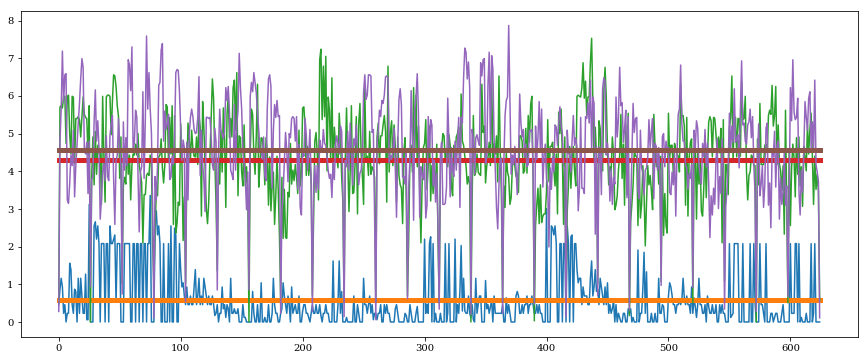

In [16]:
base_errors_2 = []
get_errors(base_results_2, base_errors_2)

static_errors_2 = []
get_errors(static_results_2, static_errors_2)

runtime_errors_2 = []
get_errors(runtime_results_2, runtime_errors_2)


plt.figure(5, figsize=(15,6))
plt.plot(base_errors_2)
mean = np.mean(base_errors_2)
plt.plot([0, len(base_errors_2)-1], [mean, mean], linewidth=5)
plt.plot(static_errors_2)
mean = np.mean(static_errors_2)
plt.plot([0, len(static_errors_2)-1], [mean, mean], linewidth=5)
plt.plot(runtime_errors_2)
mean = np.mean(runtime_errors_2)
plt.plot([0, len(runtime_errors_2)-1], [mean, mean], linewidth=5)
plt.show()

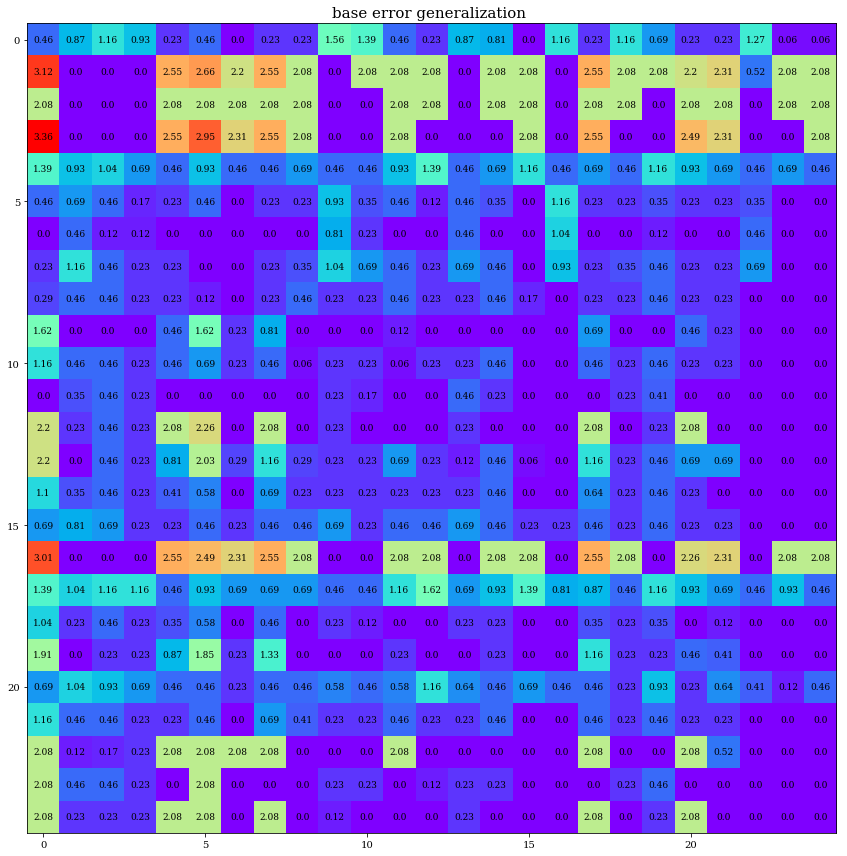

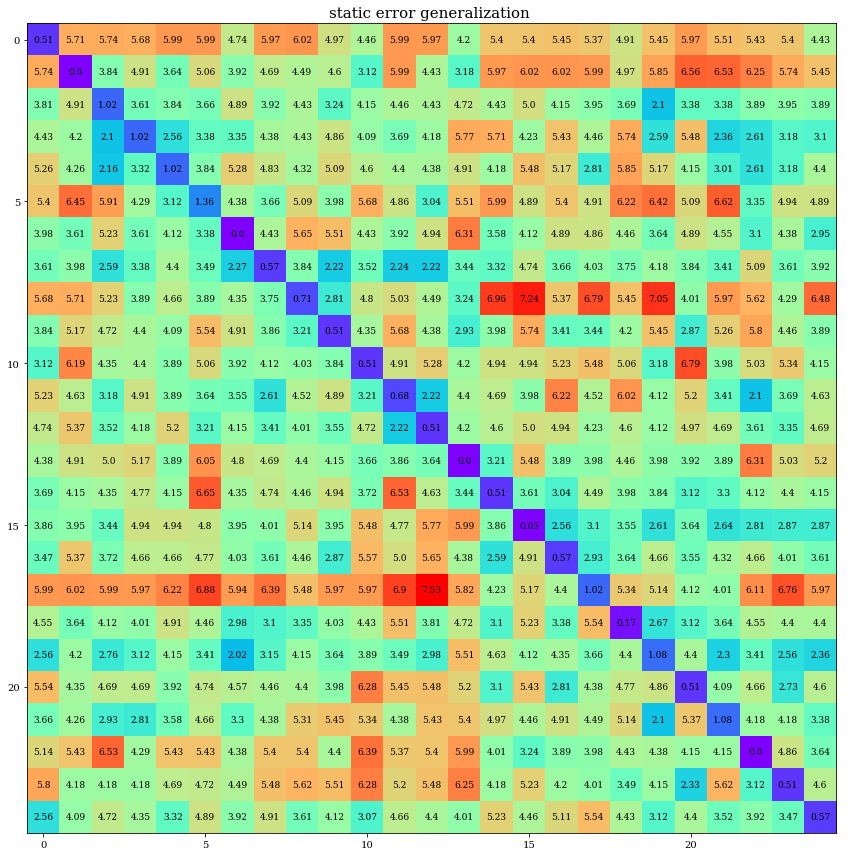

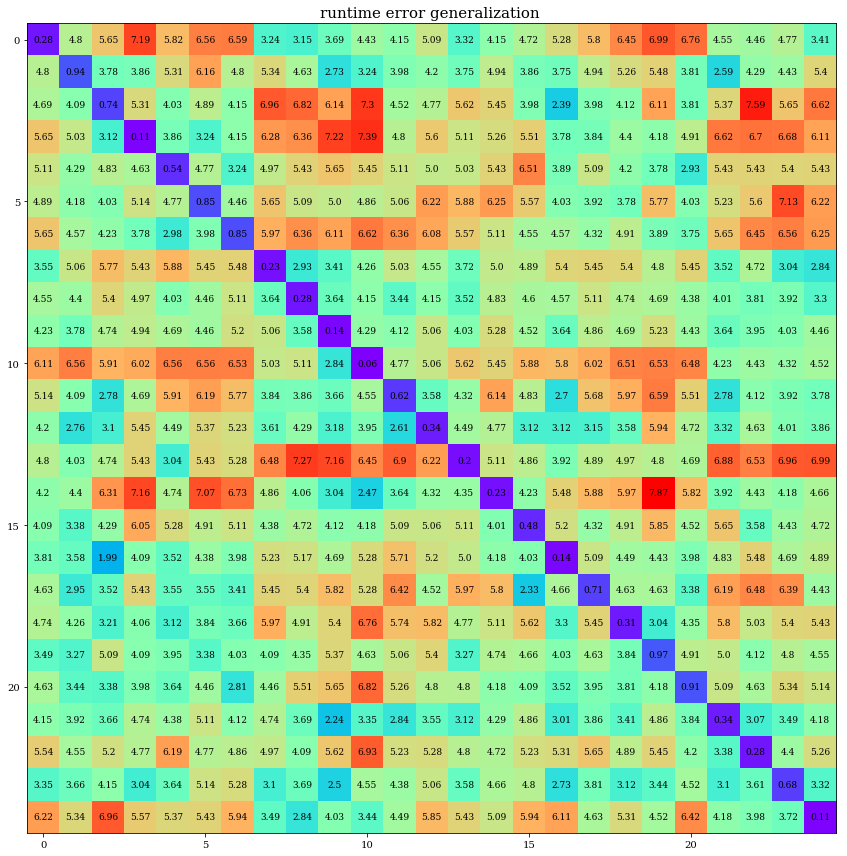

In [17]:
def get_error_matrices(errors, error_matrix):
    for i in range(0,N):
        for j in range(0,N):
            error_matrix[i][j] = errors[N*i+j]
            
base_error_matrix = np.empty([N,N], dtype=float)
get_error_matrices(base_errors_2, base_error_matrix)

static_error_matrix = np.empty([N,N], dtype=float)
get_error_matrices(static_errors_2, static_error_matrix)

runtime_error_matrix = np.empty([N,N], dtype=float)
get_error_matrices(runtime_errors_2, runtime_error_matrix)

def plot_matrices(error_matrix, mode):       
    #Display error matrix  
    fig, ax = plt.subplots(figsize=(int(N/2), int(N/2)))
    im = ax.imshow(error_matrix, cmap=colormap)
    for i in range(0,N):
        for j in range(0,N):
            text = ax.text(j, i, error_matrix[i, j], ha="center", va="center", color="black", fontsize = 9)

    ax.set_title(mode+" error generalization ", fontsize = 15)
    fig.tight_layout()
    plt.show()
    plt.savefig(mode+'_error_generalization_class_xp2.png', dpi=300)
    
plot_matrices(base_error_matrix, 'base')
plot_matrices(static_error_matrix, 'static')    
plot_matrices(runtime_error_matrix, 'runtime')  

In [14]:
def xp3(train_X, train_Y, test_X, test_Y, mode):
    results = []
    for i in range(0,N,5):    
        model = keras_model(train_X[i].shape[2], train_Y[i].shape[2])
        train_start = datetime.datetime.now()
        for j in range(i,i+5):
            model = train_and_save(model, train_X[j], train_Y[j], test_X[j], test_Y[j], mode, 100*i+j, save=False)
        model.summary()
        train_stop = datetime.datetime.now()
        train_duration = train_stop - train_start            
        for j in range(0,N):
            print('using model ', str(i), '-', str(i+4), ' on data coming from ', str(j))
            print('-------------------------')
            predict_start = datetime.datetime.now()
            error_ratio = predict(model, test_X[j], test_Y[j])
            predict_stop = datetime.datetime.now()
            predict_duration = predict_stop - predict_start
            print(error_ratio, '% error')
            print('prediction duration = ', predict_duration)
            results.append((error_ratio, train_duration, predict_duration))
    return results

base_results_3 = xp3(base_X_train_supervised, base_Y_train_supervised, base_X_test_supervised, base_Y_test_supervised, 'base')
static_results_3 = xp3(static_X_train_supervised, static_Y_train_supervised, static_X_test_supervised, static_Y_test_supervised, 'static')
runtime_results_3 = xp3(runtime_X_train_supervised, runtime_Y_train_supervised, runtime_X_test_supervised, runtime_Y_test_supervised, 'runtime')      

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 5s 106ms/step - loss: 0.5918 - acc: 0.6984 - binary_accuracy: 0.6984 - val_loss: 0.5611 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 0s 7ms/step - loss: 0.5521 - acc: 0.7083 - binary_accuracy: 0.7083 - val_loss: 0.5375 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 3/100
49/49 [==============================] - 0s 7ms/step - loss: 0.3728 - acc: 0.8197 - binary_accuracy: 0.8197 - val_loss: 0.1151 - val_acc: 0.9699 - val_binary_accuracy: 0.9699
Epoch 4/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0627 - acc: 0.9785 - binary_accuracy: 0.9785 - val_loss: 0.0450 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 5/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0376 - acc: 0.9759 - binary_accuracy: 0.9759 - val_loss: 0.0335 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 6/100
49/49 [=

49/49 [==============================] - 0s 8ms/step - loss: 0.0013 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0135 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 45/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0014 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0127 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 46/100
49/49 [==============================] - 0s 7ms/step - loss: 6.7678e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0070 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 47/100
49/49 [==============================] - 0s 7ms/step - loss: 7.4743e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0150 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 48/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0014 - acc: 0.9997 - binary_accuracy: 0.9997 - val_loss: 0.0045 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 49/100
49/49 [==============================] - 0s 7ms/step

Epoch 8/100
49/49 [==============================] - 0s 7ms/step - loss: 2.3317e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.5414e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 9/100
49/49 [==============================] - 0s 8ms/step - loss: 2.5727e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.4303e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 10/100
49/49 [==============================] - 0s 7ms/step - loss: 1.9566e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.3420e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 11/100
49/49 [==============================] - 0s 7ms/step - loss: 2.2604e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.6821e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 12/100
49/49 [==============================] - 0s 8ms/step - loss: 1.8785e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.2991e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 13/100
49/49 [==

49/49 [==============================] - 0s 7ms/step - loss: 2.9640e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.1985e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 24/100
49/49 [==============================] - 0s 8ms/step - loss: 2.8317e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.4323e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 25/100
49/49 [==============================] - 0s 7ms/step - loss: 2.1237e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 9.1778e-06 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 26/100
49/49 [==============================] - 0s 8ms/step - loss: 2.6691e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.8528e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 00026: early stopping
Epoch 00026: early stopping
Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0949 - acc: 0.9861 - binary_accuracy: 0.9861 - val_loss

0.0 % error
prediction duration =  0:00:00.003513
using model  0 - 4  on data coming from  13
-------------------------
0.0 % error
prediction duration =  0:00:00.005014
using model  0 - 4  on data coming from  14
-------------------------
0.0 % error
prediction duration =  0:00:00.004011
using model  0 - 4  on data coming from  15
-------------------------
0.0 % error
prediction duration =  0:00:00.003009
using model  0 - 4  on data coming from  16
-------------------------
0.0 % error
prediction duration =  0:00:00.003011
using model  0 - 4  on data coming from  17
-------------------------
0.0 % error
prediction duration =  0:00:00.004511
using model  0 - 4  on data coming from  18
-------------------------
0.0 % error
prediction duration =  0:00:00.003010
using model  0 - 4  on data coming from  19
-------------------------
0.0 % error
prediction duration =  0:00:00.002507
using model  0 - 4  on data coming from  20
-------------------------
0.0 % error
prediction duration =  0:00:

49/49 [==============================] - 0s 7ms/step - loss: 0.0152 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0052 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 37/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0074 - acc: 0.9955 - binary_accuracy: 0.9955 - val_loss: 0.0098 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 38/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0059 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0036 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 39/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0052 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0026 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 40/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0051 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0032 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 41/100
49/49 [==============================] - 0s 7ms/step - loss:

49/49 [==============================] - 0s 7ms/step - loss: 0.0075 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0034 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 8/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0014 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.5769e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 9/100
49/49 [==============================] - 0s 7ms/step - loss: 9.4832e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 10/100
49/49 [==============================] - 0s 7ms/step - loss: 9.4038e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 4.3072e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 11/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0010 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.4630e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 12/100
49/49 [==============================] - 0

49/49 [==============================] - 0s 7ms/step - loss: 9.2543e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 6.6556e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 23/100
49/49 [==============================] - 0s 7ms/step - loss: 8.8914e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 4.9856e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 24/100
49/49 [==============================] - 0s 7ms/step - loss: 8.2216e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 4.7692e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 25/100
49/49 [==============================] - 0s 7ms/step - loss: 7.2300e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.1215e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 26/100
49/49 [==============================] - 0s 7ms/step - loss: 7.5497e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.1067e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 00026: early stopping
Train

0.0 % error
prediction duration =  0:00:00.003480
using model  5 - 9  on data coming from  13
-------------------------
0.0 % error
prediction duration =  0:00:00.003009
using model  5 - 9  on data coming from  14
-------------------------
0.0 % error
prediction duration =  0:00:00.003007
using model  5 - 9  on data coming from  15
-------------------------
0.0 % error
prediction duration =  0:00:00.003040
using model  5 - 9  on data coming from  16
-------------------------
0.0 % error
prediction duration =  0:00:00.003008
using model  5 - 9  on data coming from  17
-------------------------
0.0 % error
prediction duration =  0:00:00.003013
using model  5 - 9  on data coming from  18
-------------------------
0.0 % error
prediction duration =  0:00:00.003478
using model  5 - 9  on data coming from  19
-------------------------
0.0 % error
prediction duration =  0:00:00.003538
using model  5 - 9  on data coming from  20
-------------------------
0.0 % error
prediction duration =  0:00:

49/49 [==============================] - 0s 7ms/step - loss: 0.0113 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0333 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 37/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0065 - acc: 0.9986 - binary_accuracy: 0.9986 - val_loss: 0.0025 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 38/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0023 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 00038: early stopping
Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0067 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 5.4311e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0036 - acc: 0.9986 - binary_accuracy: 0.9986 - val_loss: 5.1276e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0

Epoch 14/100
49/49 [==============================] - 0s 7ms/step - loss: 1.5587e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.0950e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 15/100
49/49 [==============================] - 0s 7ms/step - loss: 1.4925e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.0620e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 16/100
49/49 [==============================] - 0s 7ms/step - loss: 1.4485e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 8.1248e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 17/100
49/49 [==============================] - 0s 7ms/step - loss: 1.4330e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 8.7989e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 18/100
49/49 [==============================] - 0s 7ms/step - loss: 1.4149e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.0418e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 19/100
49/49 [

Epoch 3/100
49/49 [==============================] - 0s 7ms/step - loss: 5.7207e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 5.0244e-06 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0114 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 6.6283e-06 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
49/49 [==============================] - 0s 7ms/step - loss: 4.8987e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 4.3862e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 6/100
49/49 [==============================] - 0s 7ms/step - loss: 8.3016e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.8276e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 7/100
49/49 [==============================] - 0s 7ms/step - loss: 6.1504e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 4.5558e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 8/100
49/49 [==========

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 1s 30ms/step - loss: 0.5973 - acc: 0.7049 - binary_accuracy: 0.7049 - val_loss: 0.5602 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 0s 8ms/step - loss: 0.5525 - acc: 0.7083 - binary_accuracy: 0.7083 - val_loss: 0.5326 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 3/100
49/49 [==============================] - 0s 8ms/step - loss: 0.3841 - acc: 0.8124 - binary_accuracy: 0.8124 - val_loss: 0.0995 - val_acc: 0.9676 - val_binary_accuracy: 0.9676
Epoch 4/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0600 - acc: 0.9736 - binary_accuracy: 0.9736 - val_loss: 0.0354 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 5/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0351 - acc: 0.9847 - binary_accuracy: 0.9847 - val_loss: 0.0303 - val_acc: 0.9769 - val_binary_accuracy: 0.9769
Epoch 6/100
49/49 [==

Epoch 5/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0029 - acc: 0.9997 - binary_accuracy: 0.9997 - val_loss: 0.0036 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 6/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0030 - acc: 0.9997 - binary_accuracy: 0.9997 - val_loss: 0.0038 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 7/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0026 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 0.0016 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 8/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0019 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 8.0284e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 9/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0025 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0040 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 10/100
49/49 [==============================] - 0s 7ms/

49/49 [==============================] - 0s 7ms/step - loss: 1.3830e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 4.2823e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 22/100
49/49 [==============================] - 0s 8ms/step - loss: 1.7452e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.6316e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 23/100
49/49 [==============================] - 0s 7ms/step - loss: 2.7818e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.4913e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 24/100
49/49 [==============================] - 0s 7ms/step - loss: 1.4844e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.0769e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 25/100
49/49 [==============================] - 0s 8ms/step - loss: 2.7318e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.2077e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 26/100
49/49 [=============

49/49 [==============================] - 0s 7ms/step - loss: 8.4545e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 5.6448e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 11/100
49/49 [==============================] - 0s 8ms/step - loss: 9.9849e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 6.9132e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 12/100
49/49 [==============================] - 0s 8ms/step - loss: 7.6676e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 6.5515e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 13/100
49/49 [==============================] - 0s 7ms/step - loss: 6.9585e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.6392e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 14/100
49/49 [==============================] - 0s 7ms/step - loss: 6.2615e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.9665e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 15/100
49/49 [=============

Epoch 6/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0342 - acc: 0.9762 - binary_accuracy: 0.9762 - val_loss: 0.0314 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 7/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0303 - acc: 0.9793 - binary_accuracy: 0.9793 - val_loss: 0.0281 - val_acc: 0.9745 - val_binary_accuracy: 0.9745
Epoch 8/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0306 - acc: 0.9802 - binary_accuracy: 0.9802 - val_loss: 0.0288 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 9/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0279 - acc: 0.9816 - binary_accuracy: 0.9816 - val_loss: 0.0269 - val_acc: 0.9745 - val_binary_accuracy: 0.9745
Epoch 10/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0288 - acc: 0.9790 - binary_accuracy: 0.9790 - val_loss: 0.0273 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 11/100
49/49 [==============================] - 0s 8ms/ste

49/49 [==============================] - 0s 7ms/step - loss: 5.2648e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
49/49 [==============================] - 0s 8ms/step - loss: 4.8212e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
49/49 [==============================] - 0s 7ms/step - loss: 4.1755e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 6/100
49/49 [==============================] - 0s 8ms/step - loss: 4.5316e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 7/100
49/49 [==============================] - 0s 7ms/step - loss: 3.4242e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 8/100
49/49 [==============================] - 0s 7

49/49 [==============================] - 0s 7ms/step - loss: 4.4824e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.1640e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 20/100
49/49 [==============================] - 0s 7ms/step - loss: 3.6557e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.0414e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 21/100
49/49 [==============================] - 0s 8ms/step - loss: 3.4931e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.3023e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 22/100
49/49 [==============================] - 0s 8ms/step - loss: 3.2498e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.8560e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 23/100
49/49 [==============================] - 0s 8ms/step - loss: 2.8949e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.2471e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 24/100
49/49 [=============

Epoch 8/100
49/49 [==============================] - 0s 7ms/step - loss: 1.5368e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.7366e-06 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 9/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0015 - acc: 0.9991 - binary_accuracy: 0.9991 - val_loss: 4.2752e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 10/100
49/49 [==============================] - 0s 8ms/step - loss: 3.5993e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.0591e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 11/100
49/49 [==============================] - 0s 7ms/step - loss: 3.1553e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.6594e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 12/100
49/49 [==============================] - 0s 8ms/step - loss: 3.0805e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.4626e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 13/100
49/49 [======

99/99 [==============================] - 1s 7ms/step - loss: 0.0643 - acc: 0.9680 - binary_accuracy: 0.9680 - val_loss: 0.0523 - val_acc: 0.9769 - val_binary_accuracy: 0.9769
Epoch 4/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0615 - acc: 0.9665 - binary_accuracy: 0.9665 - val_loss: 0.0522 - val_acc: 0.9769 - val_binary_accuracy: 0.9769
Epoch 5/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0464 - acc: 0.9740 - binary_accuracy: 0.9740 - val_loss: 0.0438 - val_acc: 0.9757 - val_binary_accuracy: 0.9757
Epoch 6/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0402 - acc: 0.9776 - binary_accuracy: 0.9776 - val_loss: 0.0341 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 7/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0309 - acc: 0.9865 - binary_accuracy: 0.9865 - val_loss: 0.0449 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 8/100
99/99 [==============================] - 1s 7ms/step - loss: 0.02

99/99 [==============================] - 1s 7ms/step - loss: 0.0255 - acc: 0.9917 - binary_accuracy: 0.9917 - val_loss: 0.0229 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 5/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0212 - acc: 0.9917 - binary_accuracy: 0.9917 - val_loss: 0.0179 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 6/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0178 - acc: 0.9931 - binary_accuracy: 0.9931 - val_loss: 0.0131 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 7/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0168 - acc: 0.9923 - binary_accuracy: 0.9923 - val_loss: 0.0121 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 8/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0149 - acc: 0.9945 - binary_accuracy: 0.9945 - val_loss: 0.0128 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 9/100
99/99 [==============================] - 1s 7ms/step - loss: 0.01

Epoch 12/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0097 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0090 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 13/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0096 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0087 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 14/100
99/99 [==============================] - 1s 6ms/step - loss: 0.0091 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0082 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 15/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0092 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0083 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 16/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0086 - acc: 0.9972 - binary_accuracy: 0.9972 - val_loss: 0.0077 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 17/100
99/99 [==============================] - 1s 6ms

99/99 [==============================] - 1s 6ms/step - loss: 0.0116 - acc: 0.9949 - binary_accuracy: 0.9949 - val_loss: 0.0095 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 3/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0099 - acc: 0.9951 - binary_accuracy: 0.9951 - val_loss: 0.0101 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 4/100
99/99 [==============================] - 1s 6ms/step - loss: 0.0085 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0094 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 5/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0072 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0064 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 6/100
99/99 [==============================] - 1s 6ms/step - loss: 0.0063 - acc: 0.9985 - binary_accuracy: 0.9985 - val_loss: 0.0057 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 7/100
99/99 [==============================] - 1s 6ms/step - loss: 0.00

99/99 [==============================] - 1s 7ms/step - loss: 0.0018 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 0.0015 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 15/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0029 - acc: 0.9992 - binary_accuracy: 0.9992 - val_loss: 0.0012 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 16/100
99/99 [==============================] - 1s 7ms/step - loss: 8.0145e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 17/100
99/99 [==============================] - 1s 7ms/step - loss: 6.5650e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 6.6350e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 18/100
99/99 [==============================] - 1s 8ms/step - loss: 5.9206e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 6.9250e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 19/100
99/99 [==============================] -

Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'b']
5.14 % error
prediction duration =  0:00:00.056155
using model  0 - 4  on data coming from  8
-------------------------
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3', 'a

Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a', 'b'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'c']
3.66 % error
prediction duration =  0:00:00.008518
using model  0 - 4  on data coming from  19
-------------------------
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Tr

Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 2s 19ms/step - loss: 0.4504 - acc: 0.7889 - binary_accuracy: 0.7889 - val_loss: 0.1246 - val_acc: 0.9630 - val_binary_accuracy: 0.9630
Epoch 2/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0799 - acc: 0.9693 - binary_accuracy: 0.9693 - val_loss: 0.0616 - val_acc: 0.9699 - val_binary_accuracy: 0.9699
Epoch 3/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0526 - acc: 0.9739 - binary_accuracy: 0.9739 - val_loss: 0.0440 - val_acc: 0.9745 - val_binary_accuracy: 0.9745
Epoch 4/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0447 - acc: 0.9754 - binary_accuracy: 0.9754 - val_loss: 0.0403 - val_acc: 0.9792 - val_binary_accuracy: 0.9792
Epoch 5/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0410 - acc: 0.9756 - binary_accuracy: 0.9756 - val_loss: 0.0391 - val_acc: 0.9792 - val_binary_accuracy: 0.9792
Epoch 6/100
99/99 [=

99/99 [==============================] - 1s 6ms/step - loss: 0.0324 - acc: 0.9839 - binary_accuracy: 0.9839 - val_loss: 0.0224 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 45/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0292 - acc: 0.9844 - binary_accuracy: 0.9844 - val_loss: 0.0223 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 46/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0288 - acc: 0.9858 - binary_accuracy: 0.9858 - val_loss: 0.0220 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 47/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0271 - acc: 0.9861 - binary_accuracy: 0.9861 - val_loss: 0.0299 - val_acc: 0.9792 - val_binary_accuracy: 0.9792
Epoch 48/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0293 - acc: 0.9863 - binary_accuracy: 0.9863 - val_loss: 0.0250 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 49/100
99/99 [==============================] - 1s 7ms/step - loss:

99/99 [==============================] - 1s 7ms/step - loss: 1.0132 - acc: 0.9363 - binary_accuracy: 0.9363 - val_loss: 1.0093 - val_acc: 0.9375 - val_binary_accuracy: 0.9375
Epoch 31/100
99/99 [==============================] - 1s 7ms/step - loss: 1.0131 - acc: 0.9362 - binary_accuracy: 0.9362 - val_loss: 1.0083 - val_acc: 0.9375 - val_binary_accuracy: 0.9375
Epoch 32/100
99/99 [==============================] - 1s 8ms/step - loss: 1.0125 - acc: 0.9359 - binary_accuracy: 0.9359 - val_loss: 1.0097 - val_acc: 0.9375 - val_binary_accuracy: 0.9375
Epoch 33/100
99/99 [==============================] - 1s 8ms/step - loss: 1.0134 - acc: 0.9357 - binary_accuracy: 0.9357 - val_loss: 1.0109 - val_acc: 0.9375 - val_binary_accuracy: 0.9375
Epoch 34/100
99/99 [==============================] - 1s 7ms/step - loss: 1.0126 - acc: 0.9357 - binary_accuracy: 0.9357 - val_loss: 1.0083 - val_acc: 0.9375 - val_binary_accuracy: 0.9375
Epoch 35/100
99/99 [==============================] - 1s 8ms/step - loss:

99/99 [==============================] - 1s 7ms/step - loss: 0.0066 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0060 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 31/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0075 - acc: 0.9955 - binary_accuracy: 0.9955 - val_loss: 0.0061 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 32/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0059 - acc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 0.0066 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 33/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0065 - acc: 0.9959 - binary_accuracy: 0.9959 - val_loss: 0.0056 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 00033: early stopping
Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 1s 7ms/step - loss: 0.2998 - acc: 0.9109 - binary_accuracy: 0.9109 - val_loss: 0.0434 - val_acc: 0.9826 - val_binary_accuracy: 0.9826
Ep

99/99 [==============================] - 1s 7ms/step - loss: 0.0088 - acc: 0.9948 - binary_accuracy: 0.9948 - val_loss: 0.0065 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 41/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0080 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0077 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 42/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0087 - acc: 0.9951 - binary_accuracy: 0.9951 - val_loss: 0.0081 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 00042: early stopping
Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 1s 7ms/step - loss: 0.7290 - acc: 0.9400 - binary_accuracy: 0.9400 - val_loss: 0.3448 - val_acc: 0.9745 - val_binary_accuracy: 0.9745
Epoch 2/100
99/99 [==============================] - 1s 8ms/step - loss: 0.3433 - acc: 0.9738 - binary_accuracy: 0.9738 - val_loss: 0.3397 - val_acc: 0.9745 - val_binary_accuracy: 0.9745
Epo

Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['

Predicting  ['m2', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'c', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'c', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'c']
4.2 % error
prediction duration =  0:00:00.008524
using model  5 - 9  on data coming from  19
-------------------------
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'c', 'e'] .

Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m3', 'a', 'b'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting 

99/99 [==============================] - 1s 7ms/step - loss: 0.0304 - acc: 0.9848 - binary_accuracy: 0.9848 - val_loss: 0.0278 - val_acc: 0.9850 - val_binary_accuracy: 0.9850
Epoch 8/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0255 - acc: 0.9858 - binary_accuracy: 0.9858 - val_loss: 0.0224 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 9/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0212 - acc: 0.9871 - binary_accuracy: 0.9871 - val_loss: 0.0256 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 10/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0197 - acc: 0.9892 - binary_accuracy: 0.9892 - val_loss: 0.0191 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 11/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0197 - acc: 0.9886 - binary_accuracy: 0.9886 - val_loss: 0.0219 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 12/100
99/99 [==============================] - 1s 7ms/step - loss: 0

99/99 [==============================] - 1s 7ms/step - loss: 0.0244 - acc: 0.9867 - binary_accuracy: 0.9867 - val_loss: 0.0205 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 10/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0281 - acc: 0.9853 - binary_accuracy: 0.9853 - val_loss: 0.0219 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 11/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0215 - acc: 0.9903 - binary_accuracy: 0.9903 - val_loss: 0.0305 - val_acc: 0.9792 - val_binary_accuracy: 0.9792
Epoch 12/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0186 - acc: 0.9924 - binary_accuracy: 0.9924 - val_loss: 0.0190 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 13/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0301 - acc: 0.9868 - binary_accuracy: 0.9868 - val_loss: 0.0208 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 14/100
99/99 [==============================] - 1s 7ms/step - loss:

99/99 [==============================] - 1s 7ms/step - loss: 0.0120 - acc: 0.9931 - binary_accuracy: 0.9931 - val_loss: 0.0087 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 12/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0127 - acc: 0.9945 - binary_accuracy: 0.9945 - val_loss: 0.0082 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 13/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0114 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0078 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 14/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0108 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0078 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 15/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0107 - acc: 0.9945 - binary_accuracy: 0.9945 - val_loss: 0.0076 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 16/100
99/99 [==============================] - 1s 7ms/step - loss:

99/99 [==============================] - 1s 7ms/step - loss: 0.3440 - acc: 0.9750 - binary_accuracy: 0.9750 - val_loss: 0.3426 - val_acc: 0.9745 - val_binary_accuracy: 0.9745
Epoch 29/100
99/99 [==============================] - 1s 7ms/step - loss: 0.3440 - acc: 0.9743 - binary_accuracy: 0.9743 - val_loss: 0.3425 - val_acc: 0.9745 - val_binary_accuracy: 0.9745
Epoch 30/100
99/99 [==============================] - 1s 7ms/step - loss: 0.3438 - acc: 0.9738 - binary_accuracy: 0.9738 - val_loss: 0.3424 - val_acc: 0.9745 - val_binary_accuracy: 0.9745
Epoch 31/100
99/99 [==============================] - 1s 7ms/step - loss: 0.3439 - acc: 0.9740 - binary_accuracy: 0.9740 - val_loss: 0.3426 - val_acc: 0.9745 - val_binary_accuracy: 0.9745
Epoch 32/100
99/99 [==============================] - 1s 7ms/step - loss: 0.3440 - acc: 0.9742 - binary_accuracy: 0.9742 - val_loss: 0.3424 - val_acc: 0.9745 - val_binary_accuracy: 0.9745
Epoch 00032: early stopping
Train on 99 samples, validate on 12 samples
E

Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'b'] . Truth is  ['m2', 'b']
4.2 % error
prediction duration =  0:00:00.056152
using model  10 - 14  on data coming from  7
-------------------------
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b']
Predicting 

Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
2.87 % error
prediction duratio

99/99 [==============================] - 2s 21ms/step - loss: 0.5701 - acc: 0.7085 - binary_accuracy: 0.7085 - val_loss: 0.3499 - val_acc: 0.8565 - val_binary_accuracy: 0.8565
Epoch 2/100
99/99 [==============================] - 1s 7ms/step - loss: 0.1693 - acc: 0.9334 - binary_accuracy: 0.9334 - val_loss: 0.0869 - val_acc: 0.9653 - val_binary_accuracy: 0.9653
Epoch 3/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0697 - acc: 0.9686 - binary_accuracy: 0.9686 - val_loss: 0.0691 - val_acc: 0.9630 - val_binary_accuracy: 0.9630
Epoch 4/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0536 - acc: 0.9749 - binary_accuracy: 0.9749 - val_loss: 0.0494 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 5/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0450 - acc: 0.9781 - binary_accuracy: 0.9781 - val_loss: 0.0404 - val_acc: 0.9803 - val_binary_accuracy: 0.9803
Epoch 6/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0

99/99 [==============================] - 1s 7ms/step - loss: 0.0204 - acc: 0.9931 - binary_accuracy: 0.9931 - val_loss: 0.0334 - val_acc: 0.9826 - val_binary_accuracy: 0.9826
Epoch 3/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0157 - acc: 0.9935 - binary_accuracy: 0.9935 - val_loss: 0.0258 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 4/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0127 - acc: 0.9935 - binary_accuracy: 0.9935 - val_loss: 0.0223 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 5/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0116 - acc: 0.9944 - binary_accuracy: 0.9944 - val_loss: 0.0199 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 6/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0110 - acc: 0.9938 - binary_accuracy: 0.9938 - val_loss: 0.0166 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 7/100
99/99 [==============================] - 1s 7ms/step - loss: 0.01

99/99 [==============================] - 1s 7ms/step - loss: 0.0164 - acc: 0.9924 - binary_accuracy: 0.9924 - val_loss: 0.0166 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 9/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0165 - acc: 0.9920 - binary_accuracy: 0.9920 - val_loss: 0.0147 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 10/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0162 - acc: 0.9923 - binary_accuracy: 0.9923 - val_loss: 0.0151 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 11/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0156 - acc: 0.9926 - binary_accuracy: 0.9926 - val_loss: 0.0161 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 12/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0157 - acc: 0.9920 - binary_accuracy: 0.9920 - val_loss: 0.0141 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 13/100
99/99 [==============================] - 1s 7ms/step - loss: 

99/99 [==============================] - 1s 7ms/step - loss: 0.0024 - acc: 0.9987 - binary_accuracy: 0.9987 - val_loss: 3.0859e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 20/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0021 - acc: 0.9996 - binary_accuracy: 0.9996 - val_loss: 4.2387e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 21/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0021 - acc: 0.9987 - binary_accuracy: 0.9987 - val_loss: 0.0034 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 22/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0039 - acc: 0.9980 - binary_accuracy: 0.9980 - val_loss: 2.7048e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 23/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0020 - acc: 0.9996 - binary_accuracy: 0.9996 - val_loss: 6.3816e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 24/100
99/99 [==============================] - 1s 

99/99 [==============================] - 1s 7ms/step - loss: 0.0135 - acc: 0.9931 - binary_accuracy: 0.9931 - val_loss: 0.0131 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 34/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0137 - acc: 0.9931 - binary_accuracy: 0.9931 - val_loss: 0.0138 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 00034: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_18 (TimeDis (None, 9, 250)            3500      
_________________________________________________________________
cu_dnnlstm_9 (CuDNNLSTM)     (None, 9, 125)            188500    
_________________________________________________________________
time_distributed_19 (TimeDis (None, 9, 50)             6300      
_________________________________________________________________
dense_29 (Dense)             (None, 9, 8)              408       
Total params: 1

Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
3.38 % error
prediction duration =  0:00:00.008523
using model  15 - 19  on data coming from  8
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']

Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'b', 

Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'a', 'c']

99/99 [==============================] - 1s 7ms/step - loss: 0.0068 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0065 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 35/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0065 - acc: 0.9949 - binary_accuracy: 0.9949 - val_loss: 0.0065 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 36/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0065 - acc: 0.9942 - binary_accuracy: 0.9942 - val_loss: 0.0065 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 37/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0064 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0065 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 38/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0068 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0069 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 39/100
99/99 [==============================] - 1s 7ms/step - loss:

Epoch 4/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0292 - acc: 0.9850 - binary_accuracy: 0.9850 - val_loss: 0.0274 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 5/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0266 - acc: 0.9870 - binary_accuracy: 0.9870 - val_loss: 0.0273 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 6/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0281 - acc: 0.9858 - binary_accuracy: 0.9858 - val_loss: 0.0233 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 7/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0253 - acc: 0.9893 - binary_accuracy: 0.9893 - val_loss: 0.0224 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 8/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0238 - acc: 0.9875 - binary_accuracy: 0.9875 - val_loss: 0.0189 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 9/100
99/99 [==============================] - 1s 7ms/step 

99/99 [==============================] - 1s 7ms/step - loss: 0.1169 - acc: 0.9689 - binary_accuracy: 0.9689 - val_loss: 0.0231 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 2/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0207 - acc: 0.9889 - binary_accuracy: 0.9889 - val_loss: 0.0269 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 3/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0234 - acc: 0.9874 - binary_accuracy: 0.9874 - val_loss: 0.0190 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 4/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0205 - acc: 0.9868 - binary_accuracy: 0.9868 - val_loss: 0.0191 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 5/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0200 - acc: 0.9871 - binary_accuracy: 0.9871 - val_loss: 0.0190 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 6/100
99/99 [==============================] - 1s 7ms/step - loss: 0.01

Epoch 45/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0128 - acc: 0.9941 - binary_accuracy: 0.9941 - val_loss: 0.0145 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 46/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0144 - acc: 0.9937 - binary_accuracy: 0.9937 - val_loss: 0.0238 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 47/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0149 - acc: 0.9938 - binary_accuracy: 0.9938 - val_loss: 0.0098 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 48/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0130 - acc: 0.9958 - binary_accuracy: 0.9958 - val_loss: 0.0100 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 49/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0080 - acc: 0.9976 - binary_accuracy: 0.9976 - val_loss: 0.0085 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 50/100
99/99 [==============================] - 1s 7ms

99/99 [==============================] - 1s 7ms/step - loss: 0.9968 - acc: 0.9346 - binary_accuracy: 0.9346 - val_loss: 1.0047 - val_acc: 0.9352 - val_binary_accuracy: 0.9352
Epoch 13/100
99/99 [==============================] - 1s 7ms/step - loss: 0.9961 - acc: 0.9356 - binary_accuracy: 0.9356 - val_loss: 1.0060 - val_acc: 0.9329 - val_binary_accuracy: 0.9329
Epoch 14/100
99/99 [==============================] - 1s 7ms/step - loss: 0.9960 - acc: 0.9341 - binary_accuracy: 0.9341 - val_loss: 1.0061 - val_acc: 0.9329 - val_binary_accuracy: 0.9329
Epoch 15/100
99/99 [==============================] - 1s 7ms/step - loss: 0.9963 - acc: 0.9338 - binary_accuracy: 0.9338 - val_loss: 1.0052 - val_acc: 0.9329 - val_binary_accuracy: 0.9329
Epoch 16/100
99/99 [==============================] - 1s 7ms/step - loss: 0.9963 - acc: 0.9341 - binary_accuracy: 0.9341 - val_loss: 1.0056 - val_acc: 0.9375 - val_binary_accuracy: 0.9375
Epoch 17/100
99/99 [==============================] - 1s 7ms/step - loss:

Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a'

using model  20 - 24  on data coming from  15
-------------------------
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b',

Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . 

99/99 [==============================] - 1s 7ms/step - loss: 0.0121 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0124 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 27/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0119 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0127 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 28/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0109 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0172 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 29/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0131 - acc: 0.9951 - binary_accuracy: 0.9951 - val_loss: 0.0213 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 30/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0089 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0148 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 31/100
99/99 [==============================] - 1s 7ms/step - loss:

Epoch 11/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0365 - acc: 0.9801 - binary_accuracy: 0.9801 - val_loss: 0.0283 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 12/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0317 - acc: 0.9855 - binary_accuracy: 0.9855 - val_loss: 0.0199 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 13/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0332 - acc: 0.9826 - binary_accuracy: 0.9826 - val_loss: 0.0197 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 14/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0298 - acc: 0.9863 - binary_accuracy: 0.9863 - val_loss: 0.0163 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 15/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0334 - acc: 0.9843 - binary_accuracy: 0.9843 - val_loss: 0.0250 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 16/100
99/99 [==============================] - 1s 7ms

99/99 [==============================] - 1s 7ms/step - loss: 0.0086 - acc: 0.9972 - binary_accuracy: 0.9972 - val_loss: 0.0063 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 55/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0100 - acc: 0.9962 - binary_accuracy: 0.9962 - val_loss: 0.0166 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 56/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0081 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0100 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 57/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0101 - acc: 0.9969 - binary_accuracy: 0.9969 - val_loss: 0.0081 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 58/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0079 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0130 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 00058: early stopping
Train on 99 samples, validate on 12 samples
E

99/99 [==============================] - 1s 7ms/step - loss: 0.0195 - acc: 0.9924 - binary_accuracy: 0.9924 - val_loss: 0.0186 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 40/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0187 - acc: 0.9921 - binary_accuracy: 0.9921 - val_loss: 0.0193 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 41/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0195 - acc: 0.9898 - binary_accuracy: 0.9898 - val_loss: 0.0159 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 42/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0166 - acc: 0.9931 - binary_accuracy: 0.9931 - val_loss: 0.0239 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 43/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0175 - acc: 0.9921 - binary_accuracy: 0.9921 - val_loss: 0.0186 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 44/100
99/99 [==============================] - 1s 7ms/step - loss:

99/99 [==============================] - 1s 7ms/step - loss: 0.0091 - acc: 0.9962 - binary_accuracy: 0.9962 - val_loss: 0.0192 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 12/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0067 - acc: 0.9987 - binary_accuracy: 0.9987 - val_loss: 0.0380 - val_acc: 0.9826 - val_binary_accuracy: 0.9826
Epoch 13/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0062 - acc: 0.9980 - binary_accuracy: 0.9980 - val_loss: 0.0088 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 14/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0068 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0216 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 15/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0065 - acc: 0.9983 - binary_accuracy: 0.9983 - val_loss: 0.0111 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 16/100
99/99 [==============================] - 1s 7ms/step - loss:

99/99 [==============================] - 1s 7ms/step - loss: 0.0047 - acc: 0.9987 - binary_accuracy: 0.9987 - val_loss: 0.0192 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 21/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0053 - acc: 0.9986 - binary_accuracy: 0.9986 - val_loss: 0.0328 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 22/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0067 - acc: 0.9979 - binary_accuracy: 0.9979 - val_loss: 0.0143 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 23/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0058 - acc: 0.9979 - binary_accuracy: 0.9979 - val_loss: 0.0151 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 24/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0059 - acc: 0.9979 - binary_accuracy: 0.9979 - val_loss: 0.0340 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 25/100
99/99 [==============================] - 1s 7ms/step - loss:

Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'c']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m2'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'c']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2'] . Truth is  ['

Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m2'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
4.46 % error
prediction duration =  0:00:00.057659
using model  0 - 4  on data coming from  18
-------------------------
Predicting  ['m1', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m3', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a']
Predictin

Predicting  ['m2'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m1', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
3.52 % error
prediction duration =  0:00:00.009527
using model  0 - 4  on data coming from  24
-------------------------
Predicting  ['m2'] . Truth is  ['m2', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'a', 

Epoch 28/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0451 - acc: 0.9752 - binary_accuracy: 0.9752 - val_loss: 0.0926 - val_acc: 0.9583 - val_binary_accuracy: 0.9583
Epoch 29/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0452 - acc: 0.9785 - binary_accuracy: 0.9785 - val_loss: 0.0860 - val_acc: 0.9560 - val_binary_accuracy: 0.9560
Epoch 30/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0460 - acc: 0.9743 - binary_accuracy: 0.9743 - val_loss: 0.0964 - val_acc: 0.9583 - val_binary_accuracy: 0.9583
Epoch 31/100
99/99 [==============================] - ETA: 0s - loss: 0.0435 - acc: 0.9772 - binary_accuracy: 0.977 - 1s 7ms/step - loss: 0.0437 - acc: 0.9771 - binary_accuracy: 0.9771 - val_loss: 0.0879 - val_acc: 0.9572 - val_binary_accuracy: 0.9572
Epoch 32/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0440 - acc: 0.9787 - binary_accuracy: 0.9787 - val_loss: 0.0959 - val_acc: 0.9560 - val_binary_accuracy: 0.9

99/99 [==============================] - 1s 7ms/step - loss: 0.0134 - acc: 0.9930 - binary_accuracy: 0.9930 - val_loss: 0.0183 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 34/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0148 - acc: 0.9920 - binary_accuracy: 0.9920 - val_loss: 0.0133 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 35/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0119 - acc: 0.9930 - binary_accuracy: 0.9930 - val_loss: 0.0118 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 36/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0133 - acc: 0.9924 - binary_accuracy: 0.9924 - val_loss: 0.0196 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 37/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0108 - acc: 0.9940 - binary_accuracy: 0.9940 - val_loss: 0.0092 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 38/100
99/99 [==============================] - 1s 7ms/step - loss:

Epoch 14/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0179 - acc: 0.9909 - binary_accuracy: 0.9909 - val_loss: 0.0187 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 15/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0183 - acc: 0.9893 - binary_accuracy: 0.9893 - val_loss: 0.0199 - val_acc: 0.9850 - val_binary_accuracy: 0.9850
Epoch 16/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0173 - acc: 0.9889 - binary_accuracy: 0.9889 - val_loss: 0.0181 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 17/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0176 - acc: 0.9882 - binary_accuracy: 0.9882 - val_loss: 0.0195 - val_acc: 0.9850 - val_binary_accuracy: 0.9850
Epoch 18/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0164 - acc: 0.9916 - binary_accuracy: 0.9916 - val_loss: 0.0187 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 19/100
99/99 [==============================] - 1s 7ms

99/99 [==============================] - 1s 7ms/step - loss: 0.3522 - acc: 0.9728 - binary_accuracy: 0.9728 - val_loss: 0.3459 - val_acc: 0.9676 - val_binary_accuracy: 0.9676
Epoch 11/100
99/99 [==============================] - 1s 7ms/step - loss: 0.3519 - acc: 0.9739 - binary_accuracy: 0.9739 - val_loss: 0.3360 - val_acc: 0.9711 - val_binary_accuracy: 0.9711
Epoch 12/100
99/99 [==============================] - 1s 7ms/step - loss: 0.3535 - acc: 0.9726 - binary_accuracy: 0.9726 - val_loss: 0.3922 - val_acc: 0.9653 - val_binary_accuracy: 0.9653
Epoch 13/100
99/99 [==============================] - 1s 7ms/step - loss: 0.3547 - acc: 0.9732 - binary_accuracy: 0.9732 - val_loss: 0.3395 - val_acc: 0.9711 - val_binary_accuracy: 0.9711
Epoch 14/100
99/99 [==============================] - 1s 7ms/step - loss: 0.3511 - acc: 0.9740 - binary_accuracy: 0.9740 - val_loss: 0.3511 - val_acc: 0.9664 - val_binary_accuracy: 0.9664
Epoch 15/100
99/99 [==============================] - 1s 7ms/step - loss:

99/99 [==============================] - 1s 7ms/step - loss: 0.3523 - acc: 0.9721 - binary_accuracy: 0.9721 - val_loss: 0.3645 - val_acc: 0.9699 - val_binary_accuracy: 0.9699
Epoch 9/100
99/99 [==============================] - 1s 7ms/step - loss: 0.3519 - acc: 0.9735 - binary_accuracy: 0.9735 - val_loss: 0.3674 - val_acc: 0.9653 - val_binary_accuracy: 0.9653
Epoch 10/100
99/99 [==============================] - 1s 7ms/step - loss: 0.3542 - acc: 0.9721 - binary_accuracy: 0.9721 - val_loss: 0.3617 - val_acc: 0.9699 - val_binary_accuracy: 0.9699
Epoch 11/100
99/99 [==============================] - 1s 7ms/step - loss: 0.3522 - acc: 0.9729 - binary_accuracy: 0.9729 - val_loss: 0.3622 - val_acc: 0.9699 - val_binary_accuracy: 0.9699
Epoch 12/100
99/99 [==============================] - 1s 7ms/step - loss: 0.3512 - acc: 0.9732 - binary_accuracy: 0.9732 - val_loss: 0.3638 - val_acc: 0.9699 - val_binary_accuracy: 0.9699
Epoch 13/100
99/99 [==============================] - 1s 7ms/step - loss: 

Epoch 52/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0038 - acc: 0.9987 - binary_accuracy: 0.9987 - val_loss: 0.0113 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 53/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0071 - acc: 0.9976 - binary_accuracy: 0.9976 - val_loss: 0.0126 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 54/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0271 - acc: 0.9940 - binary_accuracy: 0.9940 - val_loss: 0.0530 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 55/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0034 - acc: 0.9990 - binary_accuracy: 0.9990 - val_loss: 0.0247 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 56/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0021 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0243 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 57/100
99/99 [==============================] - 1s 8ms

Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2',

Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m2', 'e'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'e'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'e'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Pre

Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'c']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b']
2.93 % error
prediction duration =  0:00:00.009526
using model  5 - 9  on data coming from  23
-------------------------
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicti

Epoch 18/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0503 - acc: 0.9771 - binary_accuracy: 0.9771 - val_loss: 0.0707 - val_acc: 0.9722 - val_binary_accuracy: 0.9722
Epoch 19/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0502 - acc: 0.9787 - binary_accuracy: 0.9787 - val_loss: 0.0531 - val_acc: 0.9792 - val_binary_accuracy: 0.9792
Epoch 20/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0416 - acc: 0.9809 - binary_accuracy: 0.9809 - val_loss: 0.0467 - val_acc: 0.9792 - val_binary_accuracy: 0.9792
Epoch 21/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0324 - acc: 0.9857 - binary_accuracy: 0.9857 - val_loss: 0.0473 - val_acc: 0.9769 - val_binary_accuracy: 0.9769
Epoch 22/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0303 - acc: 0.9875 - binary_accuracy: 0.9875 - val_loss: 0.0401 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 23/100
99/99 [==============================] - 1s 7ms

99/99 [==============================] - 1s 7ms/step - loss: 0.0109 - acc: 0.9944 - binary_accuracy: 0.9944 - val_loss: 0.0067 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 62/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0101 - acc: 0.9951 - binary_accuracy: 0.9951 - val_loss: 0.0070 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 63/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0120 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0068 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 64/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0147 - acc: 0.9921 - binary_accuracy: 0.9921 - val_loss: 0.0073 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 65/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0132 - acc: 0.9938 - binary_accuracy: 0.9938 - val_loss: 0.0076 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 66/100
99/99 [==============================] - 1s 7ms/step - loss:

99/99 [==============================] - 1s 7ms/step - loss: 0.0090 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0058 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 35/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0076 - acc: 0.9980 - binary_accuracy: 0.9980 - val_loss: 0.0058 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 36/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0078 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0060 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 37/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0077 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0060 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 38/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0083 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0054 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 39/100
99/99 [==============================] - 1s 7ms/step - loss:

Epoch 5/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0407 - acc: 0.9843 - binary_accuracy: 0.9843 - val_loss: 0.0932 - val_acc: 0.9699 - val_binary_accuracy: 0.9699
Epoch 6/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0324 - acc: 0.9867 - binary_accuracy: 0.9867 - val_loss: 0.0907 - val_acc: 0.9722 - val_binary_accuracy: 0.9722
Epoch 7/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0295 - acc: 0.9875 - binary_accuracy: 0.9875 - val_loss: 0.0887 - val_acc: 0.9653 - val_binary_accuracy: 0.9653
Epoch 8/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0280 - acc: 0.9891 - binary_accuracy: 0.9891 - val_loss: 0.1093 - val_acc: 0.9687 - val_binary_accuracy: 0.9687
Epoch 9/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0251 - acc: 0.9892 - binary_accuracy: 0.9892 - val_loss: 0.0919 - val_acc: 0.9722 - val_binary_accuracy: 0.9722
Epoch 10/100
99/99 [==============================] - 1s 7ms/step

99/99 [==============================] - 1s 8ms/step - loss: 0.0091 - acc: 0.9959 - binary_accuracy: 0.9959 - val_loss: 0.0393 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 20/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0085 - acc: 0.9979 - binary_accuracy: 0.9979 - val_loss: 0.0674 - val_acc: 0.9792 - val_binary_accuracy: 0.9792
Epoch 21/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0096 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0463 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 22/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0075 - acc: 0.9969 - binary_accuracy: 0.9969 - val_loss: 0.0569 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 23/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0089 - acc: 0.9962 - binary_accuracy: 0.9962 - val_loss: 0.0588 - val_acc: 0.9826 - val_binary_accuracy: 0.9826
Epoch 24/100
99/99 [==============================] - 1s 7ms/step - loss:

Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2', 'a', 'c', 'd'] . Truth is  [

Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m3', 'a', 'd'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'c', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m3']
Predicting  ['m3', 'a', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m3', 'a', 'd'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m3']
Predicting  ['m3', 'a', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m3']
Predicting  ['m3', 'a', 'd'] . Truth is  ['m3', 'a']
Predictin

Predicting  ['m2'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2'] . Truth is  ['m2', 'a']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2'] . Truth is  ['m2', 'a']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2'] . Truth is  ['m1', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3'] . Truth is  ['m2', 'b

99/99 [==============================] - 1s 7ms/step - loss: 0.0195 - acc: 0.9924 - binary_accuracy: 0.9924 - val_loss: 0.3765 - val_acc: 0.9306 - val_binary_accuracy: 0.9306
Epoch 23/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0177 - acc: 0.9927 - binary_accuracy: 0.9927 - val_loss: 0.2750 - val_acc: 0.9491 - val_binary_accuracy: 0.9491
Epoch 24/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0206 - acc: 0.9924 - binary_accuracy: 0.9924 - val_loss: 0.1874 - val_acc: 0.9572 - val_binary_accuracy: 0.9572
Epoch 25/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0196 - acc: 0.9923 - binary_accuracy: 0.9923 - val_loss: 0.2895 - val_acc: 0.9444 - val_binary_accuracy: 0.9444
Epoch 26/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0165 - acc: 0.9919 - binary_accuracy: 0.9919 - val_loss: 0.2904 - val_acc: 0.9387 - val_binary_accuracy: 0.9387
Epoch 27/100
99/99 [==============================] - 1s 7ms/step - loss:

99/99 [==============================] - 1s 7ms/step - loss: 0.0178 - acc: 0.9926 - binary_accuracy: 0.9926 - val_loss: 0.0248 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 37/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0185 - acc: 0.9923 - binary_accuracy: 0.9923 - val_loss: 0.0262 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 38/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0224 - acc: 0.9905 - binary_accuracy: 0.9905 - val_loss: 0.0197 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 39/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0165 - acc: 0.9933 - binary_accuracy: 0.9933 - val_loss: 0.0267 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 40/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0220 - acc: 0.9906 - binary_accuracy: 0.9906 - val_loss: 0.0227 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 41/100
99/99 [==============================] - 1s 7ms/step - loss:

Epoch 80/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0060 - acc: 0.9972 - binary_accuracy: 0.9972 - val_loss: 0.0092 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 81/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0046 - acc: 0.9986 - binary_accuracy: 0.9986 - val_loss: 0.0042 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 82/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0047 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0075 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 83/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0058 - acc: 0.9972 - binary_accuracy: 0.9972 - val_loss: 0.0090 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 84/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0084 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0048 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 85/100
99/99 [==============================] - 1s 7ms

Epoch 2/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0411 - acc: 0.9867 - binary_accuracy: 0.9867 - val_loss: 0.0313 - val_acc: 0.9792 - val_binary_accuracy: 0.9792
Epoch 3/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0254 - acc: 0.9916 - binary_accuracy: 0.9916 - val_loss: 0.0240 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 4/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0181 - acc: 0.9940 - binary_accuracy: 0.9940 - val_loss: 0.0148 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 5/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0129 - acc: 0.9958 - binary_accuracy: 0.9958 - val_loss: 0.0111 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 6/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0111 - acc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 0.0217 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 7/100
99/99 [==============================] - 1s 7ms/step 

Epoch 2/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0704 - acc: 0.9718 - binary_accuracy: 0.9718 - val_loss: 0.0754 - val_acc: 0.9676 - val_binary_accuracy: 0.9676
Epoch 3/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0494 - acc: 0.9788 - binary_accuracy: 0.9788 - val_loss: 0.1203 - val_acc: 0.9537 - val_binary_accuracy: 0.9537
Epoch 4/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0471 - acc: 0.9806 - binary_accuracy: 0.9806 - val_loss: 0.1390 - val_acc: 0.9525 - val_binary_accuracy: 0.9525
Epoch 5/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0459 - acc: 0.9794 - binary_accuracy: 0.9794 - val_loss: 0.0988 - val_acc: 0.9606 - val_binary_accuracy: 0.9606
Epoch 6/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0431 - acc: 0.9794 - binary_accuracy: 0.9794 - val_loss: 0.0737 - val_acc: 0.9630 - val_binary_accuracy: 0.9630
Epoch 7/100
99/99 [==============================] - 1s 7ms/step 

Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m

Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
5.17 % error
prediction duration =  0:00:00.009507
using model  15 - 19  on data coming from  13
-------------------------
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'c'] . Truth is  [

Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1'

99/99 [==============================] - 3s 30ms/step - loss: 0.4916 - acc: 0.7577 - binary_accuracy: 0.7577 - val_loss: 0.2427 - val_acc: 0.8866 - val_binary_accuracy: 0.8866
Epoch 2/100
99/99 [==============================] - 1s 9ms/step - loss: 0.1520 - acc: 0.9437 - binary_accuracy: 0.9437 - val_loss: 0.1295 - val_acc: 0.9572 - val_binary_accuracy: 0.9572
Epoch 3/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0945 - acc: 0.9634 - binary_accuracy: 0.9634 - val_loss: 0.0702 - val_acc: 0.9722 - val_binary_accuracy: 0.9722
Epoch 4/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0725 - acc: 0.9672 - binary_accuracy: 0.9672 - val_loss: 0.0529 - val_acc: 0.9769 - val_binary_accuracy: 0.9769
Epoch 5/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0587 - acc: 0.9691 - binary_accuracy: 0.9691 - val_loss: 0.0352 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 6/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0

Epoch 45/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0167 - acc: 0.9926 - binary_accuracy: 0.9926 - val_loss: 0.0100 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 46/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0176 - acc: 0.9907 - binary_accuracy: 0.9907 - val_loss: 0.0090 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 00046: early stopping
Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 1s 8ms/step - loss: 0.2969 - acc: 0.9275 - binary_accuracy: 0.9275 - val_loss: 0.0436 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 2/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0482 - acc: 0.9858 - binary_accuracy: 0.9858 - val_loss: 0.0295 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 3/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0405 - acc: 0.9877 - binary_accuracy: 0.9877 - val_loss: 0.0222 - val_acc: 0.9977 - val_binary_accuracy

Epoch 14/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0541 - acc: 0.9794 - binary_accuracy: 0.9794 - val_loss: 0.0990 - val_acc: 0.9618 - val_binary_accuracy: 0.9618
Epoch 15/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0498 - acc: 0.9783 - binary_accuracy: 0.9783 - val_loss: 0.0862 - val_acc: 0.9711 - val_binary_accuracy: 0.9711
Epoch 16/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0466 - acc: 0.9798 - binary_accuracy: 0.9798 - val_loss: 0.1061 - val_acc: 0.9456 - val_binary_accuracy: 0.9456
Epoch 17/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0522 - acc: 0.9773 - binary_accuracy: 0.9773 - val_loss: 0.1265 - val_acc: 0.9410 - val_binary_accuracy: 0.9410
Epoch 18/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0472 - acc: 0.9812 - binary_accuracy: 0.9812 - val_loss: 0.1238 - val_acc: 0.9514 - val_binary_accuracy: 0.9514
Epoch 19/100
99/99 [==============================] - 1s 8ms

99/99 [==============================] - 1s 7ms/step - loss: 0.0143 - acc: 0.9945 - binary_accuracy: 0.9945 - val_loss: 0.0137 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 58/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0132 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0221 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 59/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0162 - acc: 0.9934 - binary_accuracy: 0.9934 - val_loss: 0.0971 - val_acc: 0.9699 - val_binary_accuracy: 0.9699
Epoch 60/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0264 - acc: 0.9900 - binary_accuracy: 0.9900 - val_loss: 0.0145 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 61/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0114 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0430 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 62/100
99/99 [==============================] - 1s 7ms/step - loss:

99/99 [==============================] - 1s 7ms/step - loss: 0.0270 - acc: 0.9891 - binary_accuracy: 0.9891 - val_loss: 0.0207 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 4/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0198 - acc: 0.9924 - binary_accuracy: 0.9924 - val_loss: 0.0153 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 5/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0184 - acc: 0.9923 - binary_accuracy: 0.9923 - val_loss: 0.0151 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 6/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0146 - acc: 0.9942 - binary_accuracy: 0.9942 - val_loss: 0.0116 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 7/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0137 - acc: 0.9927 - binary_accuracy: 0.9927 - val_loss: 0.0107 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 8/100
99/99 [==============================] - 1s 8ms/step - loss: 0.01

99/99 [==============================] - 1s 7ms/step - loss: 0.0077 - acc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 0.0793 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 18/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0063 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0715 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 19/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0069 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0832 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 20/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0060 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0866 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 21/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0060 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0685 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 22/100
99/99 [==============================] - 1s 7ms/step - loss:

Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m1', 'a', 'c', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'c'] . Truth is  ['m2'

Predicting  ['m3', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'c']
3.52 % error
prediction duration =  0:00:00.009989
using model  20 - 24  on data coming from  17
-------------------------
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b'] . Tru

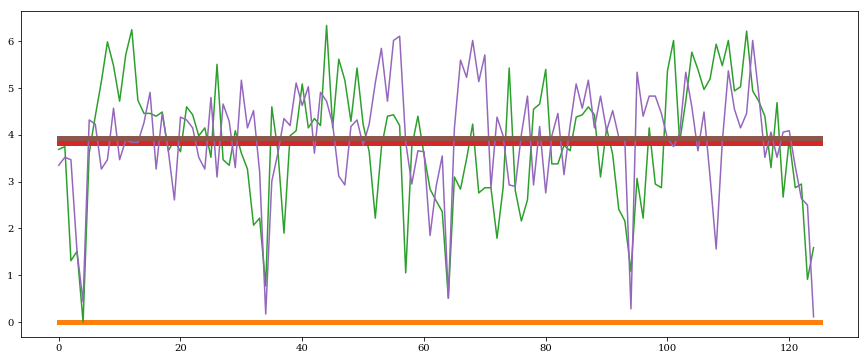

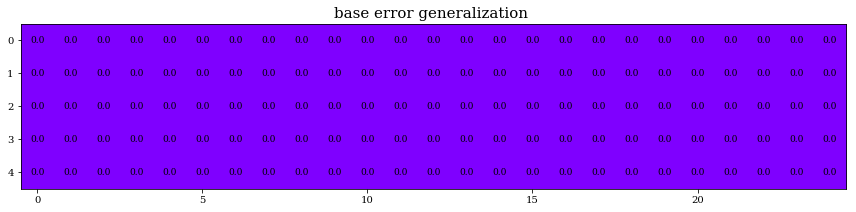

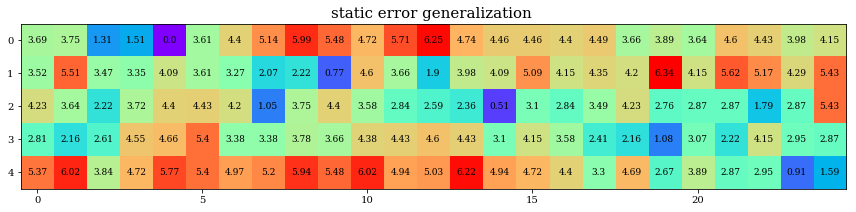

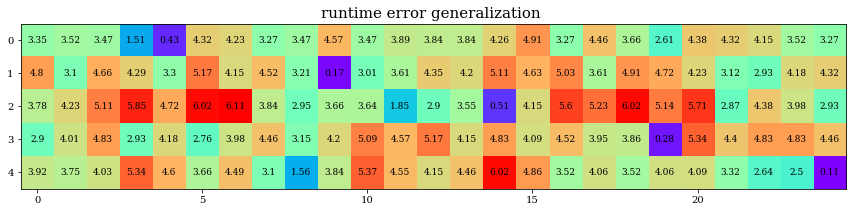

In [16]:
base_errors_3 = []
get_errors(base_results_3, base_errors_3)

static_errors_3 = []
get_errors(static_results_3, static_errors_3)

runtime_errors_3 = []
get_errors(runtime_results_3, runtime_errors_3)

plt.figure(10, figsize=(15,6))
plt.plot(base_errors_3)
mean = np.mean(base_errors_3)
plt.plot([0, len(base_errors_3)], [mean, mean], linewidth=5)
plt.plot(static_errors_3)
mean = np.mean(static_errors_3)
plt.plot([0, len(static_errors_3)], [mean, mean], linewidth=5)
plt.plot(runtime_errors_3)
mean = np.mean(runtime_errors_3)
plt.plot([0, len(runtime_errors_3)], [mean, mean], linewidth=5)
plt.show()


def get_error_matrices2(errors, error_matrix, length=N):
    for i in range(0, len(errors)):
        row = math.floor(i/length)
        col = i % length
        error_matrix[row][col] = errors[i]
            


x = math.floor(len(base_errors_3)/N)
base_error_matrix = np.empty([x,N], dtype=float)
get_error_matrices2(base_errors_3, base_error_matrix)

x = math.floor(len(static_errors_3)/N)
static_error_matrix = np.empty([x,N], dtype=float)
get_error_matrices2(static_errors_3, static_error_matrix)

x = math.floor(len(runtime_errors_3)/N)
runtime_error_matrix = np.empty([x,N], dtype=float)
get_error_matrices2(runtime_errors_3, runtime_error_matrix)


def plot_matrices2(error_matrix, mode, x=N, y=N):       
    #Display error matrix  
    fig, ax = plt.subplots(figsize=(int(N/2), int(N/2)))
    im = ax.imshow(error_matrix, cmap=colormap)
    for i in range(0,x):
        for j in range(0,y):
            text = ax.text(j, i, error_matrix[i, j], ha="center", va="center", color="black", fontsize = 9)

    ax.set_title(mode+" error generalization ", fontsize = 15)
    fig.tight_layout()
    plt.show()
    plt.savefig(mode+'_error_generalization_class_xp3.png', dpi=300)


plot_matrices2(base_error_matrix, 'base', x=5)
plot_matrices2(static_error_matrix, 'static', x=5)    
plot_matrices2(runtime_error_matrix, 'runtime', x=5) 